# Sleep Regularity Calculations Notes:

**subject data to inspect**

**remove following visits before calculating rolling SRI scores (missing)**

**subject (visits)**

**TR subjects**
- S03 (36,38)
- S09 (24)
- S10 (24-29, 34,39)
- S11 (2, 26,27)
- S23 (25)
- S25 (2,24)
- **control subjects**
- S02 (2, 3, 9, 24, 28)
- S04 (2) 
- S06 (2)
- S15 (2,3,31,36)
- S20 (4,14,18)
- S21 (5)
- S22 (10,14,18,31)
- S27 (10,12,25-29)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

In [3]:
# Step 1: Create a DataFrame with one-minute intervals from 00:00 to 23:59
time_range = pd.date_range(start="00:00", end="23:59", freq="min").time  # 1T represents 1-minute frequency
df = pd.DataFrame({'time': time_range})

# Step 2: Create a dictionary that maps each time (HH:MM) to a unique integer (1 to 1440)
time_to_epoch = {time.strftime('%H:%M'): i+1 for i, time in enumerate(time_range)}

# Step 3: Create a new column 'epoch_num' based on the dictionary
df['time_str'] = df['time'].apply(lambda x: x.strftime('%H:%M'))  # Create a column with time in 'HH:MM' format
df['epoch_num'] = df['time_str'].map(time_to_epoch)  # Map each time to the corresponding epoch number

# Display the DataFrame
df.head()  # Print the first 10 rows to verify the output


,time,time_str,epoch_num
0,00:00:00,00:00,1
1,00:01:00,00:01,2
2,00:02:00,00:02,3
3,00:03:00,00:03,4
4,00:04:00,00:04,5


In [4]:
df.dtypes

time         object
time_str     object
epoch_num     int64
dtype: object

In [5]:
# Create the time-to-epoch mapping as shown earlier
time_range = pd.date_range(start="00:00", end="23:59", freq="min").time
time_to_epoch = {time.strftime('%H:%M'): i+1 for i, time in enumerate(time_range)}

# Function to convert 'HH:MM' format to 'epoch_num'
def convert_to_epoch(time_str):
    return time_to_epoch.get(time_str, None)  # Use .get() to avoid KeyError for missing values

# Sample function that handles both sleep_time and wake_time
def map_sleep_epochs(row):
    row['sleep_epoch'] = convert_to_epoch(row['sleep_time'])
    row['wake_epoch'] = convert_to_epoch(row['wake_time'])
    return row


#Import actual data for testing

In [7]:
df_og= pd.read_excel('sleep_data_10.21.24_cleaned.xlsx')
df_og.columns= df_og.columns.str.lower()
df_og.head()

,unnamed: 0,subject,visit,day_of_participation,train_cat,ot_status,visit_date,visit_week_day,visit_day_before,sleep_duration24,...,raw_wake2_date_time24,sleep5_date_time24,wake5_date_time24,start time (scrubbed) copy,tst_1_no_formula,tst_no_formula,watch_comments,nap1_check,wake_time_self_report,start_night_sleep
0,NaN,ORE_01,2,2.0,TR,AD,2021-06-08,Tuesday,Monday,401.0,...,NaN,2021-06-07 22:12:00,2021-06-08 04:53:00,22:12:00,06:41:00,347.0,NaN,No,5:45AM,10:10PM
1,NaN,ORE_01,3,3.0,TR,AD,2021-06-09,Wednesday,Tuesday,411.0,...,NaN,2021-06-08 22:23:00,2021-06-09 05:14:00,22:23:00,06:51:00,361.0,Off for shower from 0545-0600,No,5:20AM,10:13PM
2,NaN,ORE_01,4,4.0,TR,AD,2021-06-10,Thursday,Wednesday,388.0,...,NaN,2021-06-09 22:50:00,2021-06-10 05:18:00,22:50:00,06:28:00,347.0,0550-0605: shower,No,5:41AM,10:48PM
3,NaN,ORE_01,5,5.0,TR,AD,2021-06-11,Friday,Thursday,425.0,...,NaN,2021-06-10 22:54:00,2021-06-11 05:59:00,22:54:00,07:05:00,344.0,0550-0600: shower,No,6:01AM,10:50PM
4,NaN,ORE_01,6,6.0,TR,AD,2021-06-12,Saturday,Friday,403.0,...,NaN,2021-06-11 22:55:00,2021-06-12 05:38:00,22:55:00,06:43:00,352.0,1400-1415: shower,No,06:10AM,10:50PM


In [8]:
# Convert sleep/wake columns to datetime, including possible None values
datetime_columns = ['sleep1_date_time24', 'wake1_date_time24', 
                    'sleep2_date_time24', 'wake2_date_time24', 
                    'sleep3_date_time24', 'wake3_date_time24',
                    'sleep4_date_time24', 'wake4_date_time24',
                    'visit_date']

for col in datetime_columns:
    df_og[col]= pd.to_datetime(df_og[col], errors='coerce')

df_og.dtypes

unnamed: 0               float64
subject                   object
visit                     object
day_of_participation     float64
train_cat                 object
                          ...   
tst_no_formula           float64
watch_comments            object
nap1_check                object
wake_time_self_report     object
start_night_sleep         object
Length: 100, dtype: object

#isolate one subject's data for testing

In [10]:
cols_to_keep= [
'subject', 'visit', 'day_of_participation', 'train_cat', 'visit_date','ot_status', 'sleep1_date_time24', 'wake1_date_time24',
    'main_sleep', 'sleep1_sleep2_main', 'sleep2_main',
    'sleep3_main', 'sleep2_sleep3_main', 'sleep_duration24', 'tst_24', 'sleep2_date_time24',
    'wake2_date_time24', 'sleep3_date_time24', 'wake3_date_time24', 'sleep4_date_time24', 'wake4_date_time24']

In [11]:
# ###create individual DataFrames for each subject
# #### If I want to take all columns instead of filtering only certain ones. 

# subjects= df_og['subject'].unique()

# for subject in subjects:
#     subject_df= df_og[df_og['subject']== subject]

#     globals()[f"{subject}_df"]= subject_df


In [12]:
###create individual DataFrames for each subject
subjects= df_og['subject'].unique()

for subject in subjects:
    subject_df= df_og[df_og['subject']== subject][cols_to_keep]
    #### If I want to only include certain columns for each individual datset for each subject. 
    globals()[f"{subject}_df"]= subject_df

  

In [13]:
### Showing that the above for loop worked to create individual subject dataframes. 

# ORE_01_df.head()   ## example here (starting with ORE_01_df anyways).

In [14]:
s01_df= ORE_01_df[cols_to_keep].copy()

# s1_df= s1_df.copy()     #### If I want to take all columns instead of filtering only certain ones. 


s01_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
0,ORE_01,2,2.0,TR,2021-06-08,AD,2021-06-07 22:12:00,2021-06-08 04:53:00,Sleep1,MAIN,...,NO,SLEEP_2,401.0,347.0,NaT,NaT,NaT,NaT,NaT,NaT
1,ORE_01,3,3.0,TR,2021-06-09,AD,2021-06-08 22:23:00,2021-06-09 05:14:00,Sleep1,MAIN,...,NO,SLEEP_2,411.0,361.0,NaT,NaT,NaT,NaT,NaT,NaT
2,ORE_01,4,4.0,TR,2021-06-10,AD,2021-06-09 22:50:00,2021-06-10 05:18:00,Sleep1,MAIN,...,NO,SLEEP_2,388.0,347.0,NaT,NaT,NaT,NaT,NaT,NaT
3,ORE_01,5,5.0,TR,2021-06-11,AD,2021-06-10 22:54:00,2021-06-11 05:59:00,Sleep1,MAIN,...,NO,SLEEP_2,425.0,344.0,NaT,NaT,NaT,NaT,NaT,NaT
4,ORE_01,6,6.0,TR,2021-06-12,AD,2021-06-11 22:55:00,2021-06-12 05:38:00,Sleep1,MAIN,...,NO,SLEEP_2,403.0,352.0,NaT,NaT,NaT,NaT,NaT,NaT


In [15]:
s01_df.columns

Index(['subject', 'visit', 'day_of_participation', 'train_cat', 'visit_date',
       'ot_status', 'sleep1_date_time24', 'wake1_date_time24', 'main_sleep',
       'sleep1_sleep2_main', 'sleep2_main', 'sleep3_main',
       'sleep2_sleep3_main', 'sleep_duration24', 'tst_24',
       'sleep2_date_time24', 'wake2_date_time24', 'sleep3_date_time24',
       'wake3_date_time24', 'sleep4_date_time24', 'wake4_date_time24'],
      dtype='object')

In [16]:
# Convert sleep/wake columns to datetime, including possible None values
datetime_columns = ['sleep1_date_time24', 'wake1_date_time24', 
                    'sleep2_date_time24', 'wake2_date_time24', 
                    'sleep3_date_time24', 'wake3_date_time24',
                    'sleep4_date_time24', 'wake4_date_time24','visit_date']

for col in datetime_columns:
    s01_df[col]= pd.to_datetime(s01_df[col], errors='coerce')

s01_df.dtypes

subject                         object
visit                           object
day_of_participation           float64
train_cat                       object
visit_date              datetime64[ns]
ot_status                       object
sleep1_date_time24      datetime64[ns]
wake1_date_time24       datetime64[ns]
main_sleep                      object
sleep1_sleep2_main              object
sleep2_main                     object
sleep3_main                     object
sleep2_sleep3_main              object
sleep_duration24               float64
tst_24                         float64
sleep2_date_time24      datetime64[ns]
wake2_date_time24       datetime64[ns]
sleep3_date_time24      datetime64[ns]
wake3_date_time24       datetime64[ns]
sleep4_date_time24      datetime64[ns]
wake4_date_time24       datetime64[ns]
dtype: object

In [17]:
s01_df.isna().sum()

subject                  0
visit                    0
day_of_participation     0
train_cat                0
visit_date               0
ot_status                0
sleep1_date_time24       0
wake1_date_time24        0
main_sleep               0
sleep1_sleep2_main       0
sleep2_main              0
sleep3_main              0
sleep2_sleep3_main       0
sleep_duration24         0
tst_24                   0
sleep2_date_time24      41
wake2_date_time24       41
sleep3_date_time24      41
wake3_date_time24       41
sleep4_date_time24      41
wake4_date_time24       41
dtype: int64

In [18]:
# Function to convert sleep and wake times to epoch values based on visit_date
def epoch_conversion(visit_date, sleep_time, wake_time):
    # Sleep time conversion
    if sleep_time.date() < visit_date.date():
        sleep_epoch = (sleep_time.hour * 60 + sleep_time.minute) - 1440  # Negative epoch for previous day
    else:
        sleep_epoch = sleep_time.hour * 60 + sleep_time.minute
    
    # Wake time conversion
    if wake_time.date() < visit_date.date():
        wake_epoch = (wake_time.hour * 60 + wake_time.minute) - 1440
    else:
        wake_epoch = wake_time.hour * 60 + wake_time.minute
    
    return sleep_epoch, wake_epoch

In [19]:
# Apply the epoch conversion to all three sets of sleep-wake data
def convert_multiple_sleep_epochs(df):
     # Convert sleep2 and wake2 (handle NaT cases)
    df[['sleep1_epoch', 'wake1_epoch']] = df.apply(lambda row: epoch_conversion(row['visit_date'], row['sleep1_date_time24'], row['wake1_date_time24']) if pd.notna(row['sleep1_date_time24']) and pd.notna(row['wake1_date_time24']) else (None, None), axis=1, result_type='expand')
    
    # Convert sleep2 and wake2 (handle NaT cases)
    df[['sleep2_epoch', 'wake2_epoch']] = df.apply(lambda row: epoch_conversion(row['visit_date'], row['sleep2_date_time24'], row['wake2_date_time24']) if pd.notna(row['sleep2_date_time24']) and pd.notna(row['wake2_date_time24']) else (None, None), axis=1, result_type='expand')
    
    # Convert sleep3 and wake3 (handle NaT cases)
    df[['sleep3_epoch', 'wake3_epoch']] = df.apply(lambda row: epoch_conversion(row['visit_date'], row['sleep3_date_time24'], row['wake3_date_time24']) if pd.notna(row['sleep3_date_time24']) and pd.notna(row['wake3_date_time24']) else (None, None), axis=1, result_type='expand')

        # Convert sleep3 and wake3 (handle NaT cases)
    df[['sleep4_epoch', 'wake4_epoch']] = df.apply(lambda row: epoch_conversion(row['visit_date'], row['sleep4_date_time24'], row['wake4_date_time24']) if pd.notna(row['sleep4_date_time24']) and pd.notna(row['wake4_date_time24']) else (None, None), axis=1, result_type='expand')
    
    return df

# Big step here

In [21]:
convert_multiple_sleep_epochs(s01_df)

s01_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
0,ORE_01,2,2.0,TR,2021-06-08,AD,2021-06-07 22:12:00,2021-06-08 04:53:00,Sleep1,MAIN,...,NaT,NaT,-108,293,None,None,None,None,None,None
1,ORE_01,3,3.0,TR,2021-06-09,AD,2021-06-08 22:23:00,2021-06-09 05:14:00,Sleep1,MAIN,...,NaT,NaT,-97,314,None,None,None,None,None,None
2,ORE_01,4,4.0,TR,2021-06-10,AD,2021-06-09 22:50:00,2021-06-10 05:18:00,Sleep1,MAIN,...,NaT,NaT,-70,318,None,None,None,None,None,None
3,ORE_01,5,5.0,TR,2021-06-11,AD,2021-06-10 22:54:00,2021-06-11 05:59:00,Sleep1,MAIN,...,NaT,NaT,-66,359,None,None,None,None,None,None
4,ORE_01,6,6.0,TR,2021-06-12,AD,2021-06-11 22:55:00,2021-06-12 05:38:00,Sleep1,MAIN,...,NaT,NaT,-65,338,None,None,None,None,None,None


In [22]:
###### this code works the same as convert_multiple_sleep_epochs...
### created this cell in case I don't want to run as a full function but do epoch_conversion by each sleep-wake column pair


# # Convert sleep2 and wake2 (handle NaT cases)
# s1_df[['sleep1_epoch', 'wake1_epoch']] = s1_df.apply(lambda row: epoch_conversion(row['visit_date'], row['sleep1_date_time24'], row['wake1_date_time24']) if pd.notna(row['sleep1_date_time24']) and pd.notna(row['wake1_date_time24']) else (None, None), axis=1, result_type='expand')
    
#     # Convert sleep2 and wake2 (handle NaT cases)
# s1_df[['sleep2_epoch', 'wake2_epoch']] = s1_df.apply(lambda row: epoch_conversion(row['visit_date'], row['sleep2_date_time24'], row['wake2_date_time24']) if pd.notna(row['sleep2_date_time24']) and pd.notna(row['wake2_date_time24']) else (None, None), axis=1, result_type='expand')
    
#     # Convert sleep3 and wake3 (handle NaT cases)
# s1_df[['sleep3_epoch', 'wake3_epoch']] = s1_df.apply(lambda row: epoch_conversion(row['visit_date'], row['sleep3_date_time24'], row['wake3_date_time24']) if pd.notna(row['sleep3_date_time24']) and pd.notna(row['wake3_date_time24']) else (None, None), axis=1, result_type='expand')


In [23]:
# # Generate 1440-row time-epoch dataframe and map sleep epochs
# def create_full_epoch_df(df):
#     all_epochs = []
    
#     # Iterate through each visit date
#     for visit_date in df['visit_date'].unique():
#         visit_df = df[df['visit_date'] == visit_date]
        
#         # Create a time-epoch DataFrame with 1440 rows (one for each minute of the day)
#         epoch_df = pd.DataFrame({'time_epoch': range(-720, 720), 'visit_date': visit_date})
        
#         # Map sleep epochs for sleep1, sleep2, and sleep3
#         for _, row in visit_df.iterrows():
#             # Mark sleep1
#             if pd.notna(row['sleep1_epoch']) and pd.notna(row['wake1_epoch']):
#                 epoch_df.loc[(epoch_df['time_epoch'] >= row['sleep1_epoch']) & (epoch_df['time_epoch'] <= row['wake1_epoch']), 'SRI_index'] = 1
            
#             # Mark sleep2
#             if pd.notna(row['sleep2_epoch']) and pd.notna(row['wake2_epoch']):
#                 epoch_df.loc[(epoch_df['time_epoch'] >= row['sleep2_epoch']) & (epoch_df['time_epoch'] <= row['wake2_epoch']), 'SRI_index'] = 1
            
#             # Mark sleep3
#             if pd.notna(row['sleep3_epoch']) and pd.notna(row['wake3_epoch']):
#                 epoch_df.loc[(epoch_df['time_epoch'] >= row['sleep3_epoch']) & (epoch_df['time_epoch'] <= row['wake3_epoch']), 'SRI_index'] = 1
        
#         # Fill any missing SRI_index values with 0 (indicating wake)
#         epoch_df['SRI_index'] = epoch_df['SRI_index'].fillna(0)
        
#         all_epochs.append(epoch_df)
    
#     # Concatenate all visit_date-specific DataFrames
#     full_epoch_df = pd.concat(all_epochs, ignore_index=True)
    
#     return full_epoch_df


In [24]:
def create_full_epoch_df(df):
    all_epochs = []
    
    # Iterate through each unique combination of subject, visit_date, and day_of_participation
    for subject, visit_date, day_of_participation in df[['subject', 'visit_date', 'day_of_participation']].drop_duplicates().itertuples(index=False):
        visit_df = df[(df['subject'] == subject) & 
                      (df['visit_date'] == visit_date) & 
                      (df['day_of_participation'] == day_of_participation)]
        
        # Create a time-epoch DataFrame with 1440 rows (one for each minute of the day)
        epoch_df = pd.DataFrame({'time_epoch': range(-720, 720)})
        epoch_df['visit_date'] = visit_date
        epoch_df['subject'] = subject
        epoch_df['day_of_participation'] = day_of_participation
        
        # Initialize the SRI_index column with 0 (indicating wake by default)
        epoch_df['SRI_index'] = 0
        
        # Map sleep epochs for sleep1, sleep2, and sleep3
        for _, row in visit_df.iterrows():
            # Mark sleep1
            if pd.notna(row['sleep1_epoch']) and pd.notna(row['wake1_epoch']):
                epoch_df.loc[(epoch_df['time_epoch'] >= row['sleep1_epoch']) & (epoch_df['time_epoch'] <= row['wake1_epoch']), 'SRI_index'] = 1
            
            # Mark sleep2
            if pd.notna(row['sleep2_epoch']) and pd.notna(row['wake2_epoch']):
                epoch_df.loc[(epoch_df['time_epoch'] >= row['sleep2_epoch']) & (epoch_df['time_epoch'] <= row['wake2_epoch']), 'SRI_index'] = 1
            
            # Mark sleep3
            if pd.notna(row['sleep3_epoch']) and pd.notna(row['wake3_epoch']):
                epoch_df.loc[(epoch_df['time_epoch'] >= row['sleep3_epoch']) & (epoch_df['time_epoch'] <= row['wake3_epoch']), 'SRI_index'] = 1
            
            # Mark sleep4
            if pd.notna(row['sleep4_epoch']) and pd.notna(row['wake4_epoch']):
                epoch_df.loc[(epoch_df['time_epoch'] >= row['sleep4_epoch']) & (epoch_df['time_epoch'] <= row['wake4_epoch']), 'SRI_index'] = 1
        
        # Append the epoch data for the current subject and visit date
        all_epochs.append(epoch_df)
    
    # Concatenate all subject/visit_date/day_of_participation-specific DataFrames
    full_epoch_df = pd.concat(all_epochs, ignore_index=True)
    full_epoch_df = full_epoch_df.iloc[:, [2,1,3,0,4]]
    return full_epoch_df

In [25]:
s01_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
0,ORE_01,2,2.0,TR,2021-06-08,AD,2021-06-07 22:12:00,2021-06-08 04:53:00,Sleep1,MAIN,...,NaT,NaT,-108,293,None,None,None,None,None,None
1,ORE_01,3,3.0,TR,2021-06-09,AD,2021-06-08 22:23:00,2021-06-09 05:14:00,Sleep1,MAIN,...,NaT,NaT,-97,314,None,None,None,None,None,None
2,ORE_01,4,4.0,TR,2021-06-10,AD,2021-06-09 22:50:00,2021-06-10 05:18:00,Sleep1,MAIN,...,NaT,NaT,-70,318,None,None,None,None,None,None
3,ORE_01,5,5.0,TR,2021-06-11,AD,2021-06-10 22:54:00,2021-06-11 05:59:00,Sleep1,MAIN,...,NaT,NaT,-66,359,None,None,None,None,None,None
4,ORE_01,6,6.0,TR,2021-06-12,AD,2021-06-11 22:55:00,2021-06-12 05:38:00,Sleep1,MAIN,...,NaT,NaT,-65,338,None,None,None,None,None,None


In [26]:
s01_full_epoch= create_full_epoch_df(s01_df)

s01_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_01,2021-06-08,2.0,-720,0
1,ORE_01,2021-06-08,2.0,-719,0
2,ORE_01,2021-06-08,2.0,-718,0
3,ORE_01,2021-06-08,2.0,-717,0
4,ORE_01,2021-06-08,2.0,-716,0


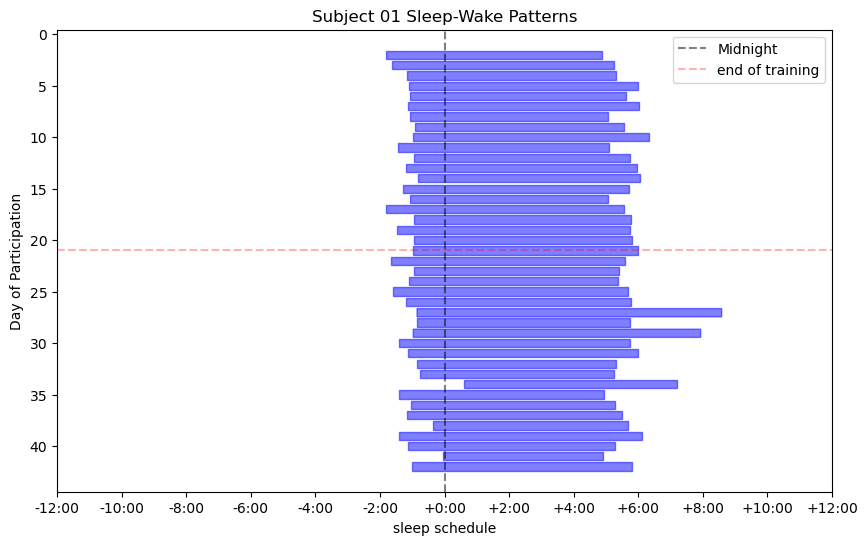

In [27]:
# Function to convert epoch to time string (HH:MM)
def epoch_to_time(epoch):
    hours = epoch // 60
    minutes = epoch % 60
    time_str = f"{hours:+02d}:{abs(minutes):02d}"
    return time_str

# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s01_full_epoch['day_of_participation'].unique():
    day_df = s01_full_epoch[s01_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 01 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 01 sleep-wake patterns.png')

# Show the plot
plt.show()


# Check in

**everything is working up to here**
Subject 1 complete

In [29]:
# Function to calculate SRI between two successive days
def calculate_sri(day1_df, day2_df):
    """
    Calculate Sleep Regularity Index (SRI) between two days.
    
    Parameters:
    day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
    day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
    Returns:
    float: SRI score (percentage of matching epochs between the two days).
    """
    # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
    merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
                         day2_df[['time_epoch', 'SRI_index']], 
                         on='time_epoch', 
                         suffixes=('_day1', '_day2'))
    
    # Calculate how many epochs have the same SRI_index for both days
    matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
    # Total number of epochs (should be 1441 if both days have full 1441-minute data)
    total_epochs = len(merged_df)
    
    # Calculate the SRI as the percentage of matching epochs
    sri_score = (matching_epochs / total_epochs) * 100
    
    return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s01_df['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s1_result_df_sorted = s01_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s1_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s1_result_df_sorted[s1_result_df_sorted['day_of_participation'] == day1]
    day2_df = s1_result_df_sorted[s1_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s01_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
s01_sri_scores_df.head().round(2)


,subject,day1,day2,SRI_score
0,ORE_01,2.0,3.0,97.78
1,ORE_01,3.0,4.0,97.85
2,ORE_01,4.0,5.0,96.88
3,ORE_01,5.0,6.0,98.47
4,ORE_01,6.0,7.0,98.19


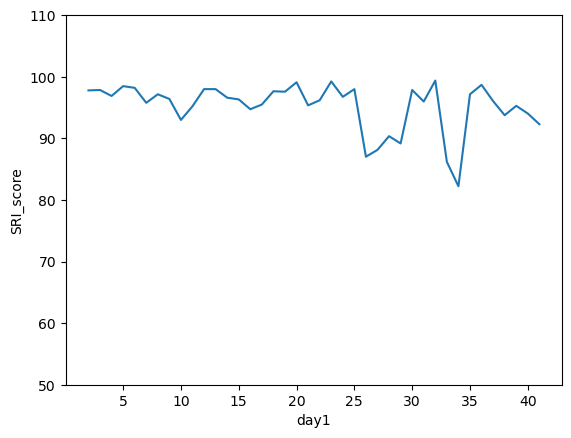

In [30]:
ax= sns.lineplot(data=s01_sri_scores_df, x='day1', y='SRI_score')

ax.set_yticks(np.arange(50,111,10))
# ax.set_yticks(np.arange(0,101,10))
plt.show()

# End Subject 1 SRI calculation


# Start of Subject 3 SRI calculation

In [33]:
s03_df= ORE_03_df[cols_to_keep].copy()

In [34]:
s03_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
41,ORE_03,2,2.0,TR,2021-09-10,OR,2021-09-09 23:03:00,2021-09-10 06:11:00,Sleep1,MAIN,...,NO,SLEEP_2,428.0,387.0,NaT,NaT,NaT,NaT,NaT,NaT
42,ORE_03,3,3.0,TR,2021-09-11,OR,2021-09-11 00:14:00,2021-09-11 06:31:00,Sleep1,MAIN,...,NO,SLEEP_2,377.0,352.0,NaT,NaT,NaT,NaT,NaT,NaT
43,ORE_03,4,4.0,TR,2021-09-12,OR,2021-09-12 00:28:00,2021-09-12 06:31:00,Sleep1,MAIN,...,NO,SLEEP_2,449.0,409.0,2021-09-11 16:12:00,2021-09-11 17:38:00,NaT,NaT,NaT,NaT
44,ORE_03,5,5.0,TR,2021-09-13,OR,2021-09-13 01:49:00,2021-09-13 06:07:00,Sleep1,MAIN,...,NO,SLEEP_2,258.0,228.0,NaT,NaT,NaT,NaT,NaT,NaT
45,ORE_03,6,6.0,TR,2021-09-14,OR,2021-09-14 00:52:00,2021-09-14 06:19:00,Sleep1,MAIN,...,NO,SLEEP_2,327.0,297.0,NaT,NaT,NaT,NaT,NaT,NaT


In [35]:
# Convert sleep/wake columns to datetime, including possible None values
datetime_columns = ['sleep1_date_time24', 'wake1_date_time24', 
                    'sleep2_date_time24', 'wake2_date_time24', 
                    'sleep3_date_time24', 'wake3_date_time24', 'visit_date']

for col in datetime_columns:
    s03_df[col]= pd.to_datetime(s03_df[col], errors='coerce')

s03_df.dtypes

subject                         object
visit                           object
day_of_participation           float64
train_cat                       object
visit_date              datetime64[ns]
ot_status                       object
sleep1_date_time24      datetime64[ns]
wake1_date_time24       datetime64[ns]
main_sleep                      object
sleep1_sleep2_main              object
sleep2_main                     object
sleep3_main                     object
sleep2_sleep3_main              object
sleep_duration24               float64
tst_24                         float64
sleep2_date_time24      datetime64[ns]
wake2_date_time24       datetime64[ns]
sleep3_date_time24      datetime64[ns]
wake3_date_time24       datetime64[ns]
sleep4_date_time24      datetime64[ns]
wake4_date_time24       datetime64[ns]
dtype: object

#

**convert times to time_epochs**



In [37]:
convert_multiple_sleep_epochs(s03_df)

s03_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
41,ORE_03,2,2.0,TR,2021-09-10,OR,2021-09-09 23:03:00,2021-09-10 06:11:00,Sleep1,MAIN,...,NaT,NaT,-57.0,371.0,NaN,NaN,None,None,None,None
42,ORE_03,3,3.0,TR,2021-09-11,OR,2021-09-11 00:14:00,2021-09-11 06:31:00,Sleep1,MAIN,...,NaT,NaT,14.0,391.0,NaN,NaN,None,None,None,None
43,ORE_03,4,4.0,TR,2021-09-12,OR,2021-09-12 00:28:00,2021-09-12 06:31:00,Sleep1,MAIN,...,NaT,NaT,28.0,391.0,-468.0,-382.0,None,None,None,None
44,ORE_03,5,5.0,TR,2021-09-13,OR,2021-09-13 01:49:00,2021-09-13 06:07:00,Sleep1,MAIN,...,NaT,NaT,109.0,367.0,NaN,NaN,None,None,None,None
45,ORE_03,6,6.0,TR,2021-09-14,OR,2021-09-14 00:52:00,2021-09-14 06:19:00,Sleep1,MAIN,...,NaT,NaT,52.0,379.0,NaN,NaN,None,None,None,None


In [38]:
s03_full_epoch= create_full_epoch_df(s03_df)

s03_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_03,2021-09-10,2.0,-720,0
1,ORE_03,2021-09-10,2.0,-719,0
2,ORE_03,2021-09-10,2.0,-718,0
3,ORE_03,2021-09-10,2.0,-717,0
4,ORE_03,2021-09-10,2.0,-716,0


In [39]:
s03_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_03,2021-09-10,2.0,-720,0
1,ORE_03,2021-09-10,2.0,-719,0
2,ORE_03,2021-09-10,2.0,-718,0
3,ORE_03,2021-09-10,2.0,-717,0
4,ORE_03,2021-09-10,2.0,-716,0


In [40]:
S03_visits_to_drop = [36,38]

s03_full_epoch = s03_full_epoch[~s03_full_epoch['day_of_participation'].isin(S03_visits_to_drop)]

# Check unique values in 'day_of_participation' after dropping
list(s03_full_epoch['day_of_participation'].unique())


[2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 37.0,
 39.0,
 40.0,
 41.0,
 42.0]

# Plot data to double check epoch conversions

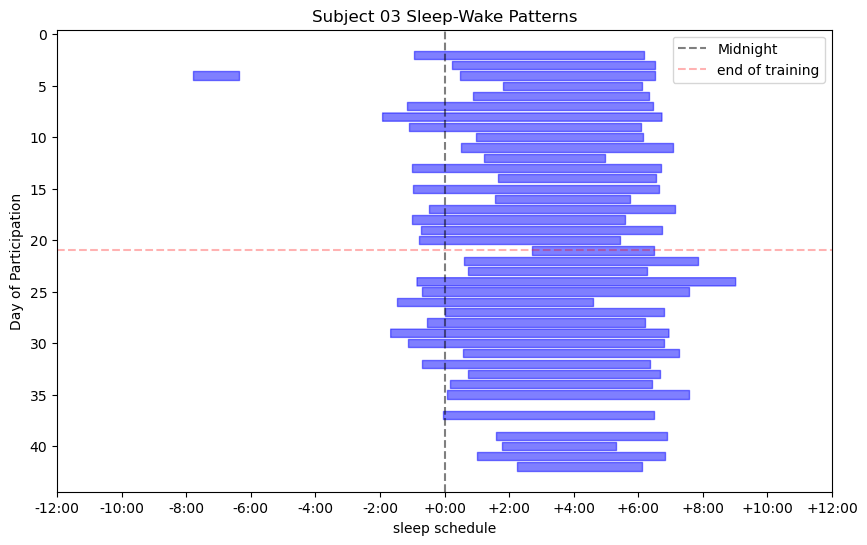

In [42]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s03_full_epoch['day_of_participation'].unique():
    day_df = s03_full_epoch[s03_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 03 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 03 sleep-wake patterns.png')

# Show the plot
plt.show()


#### 36 and 38 are removed from data as they do not have sleep data (gaps are correct to interpret missing data)

# generate SRI scores

In [44]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s03_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s03_result_df_sorted = s03_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s03_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s03_result_df_sorted[s03_result_df_sorted['day_of_participation'] == day1]
    day2_df = s03_result_df_sorted[s03_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s03_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
s03_sri_scores_df.head().round(2)


,subject,day1,day2,SRI_score
0,ORE_03,2.0,3.0,93.68
1,ORE_03,3.0,4.0,92.99
2,ORE_03,4.0,5.0,86.67
3,ORE_03,5.0,6.0,95.21
4,ORE_03,6.0,7.0,91.04


In [45]:
s03_sri_scores_df.head(40)

,subject,day1,day2,SRI_score
0,ORE_03,2.0,3.0,93.680556
1,ORE_03,3.0,4.0,92.986111
2,ORE_03,4.0,5.0,86.666667
3,ORE_03,5.0,6.0,95.208333
4,ORE_03,6.0,7.0,91.041667
5,ORE_03,7.0,8.0,95.625000
6,ORE_03,8.0,9.0,93.888889
7,ORE_03,9.0,10.0,91.111111
8,ORE_03,10.0,11.0,94.097222
9,ORE_03,11.0,12.0,88.263889


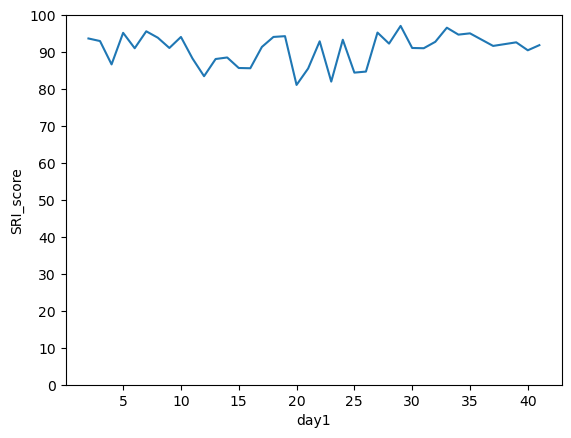

In [46]:
ax= sns.lineplot(data=s03_sri_scores_df, x='day1', y='SRI_score')

# ax.set_yticks(np.arange(50,111,10))
ax.set_yticks(np.arange(0,101,10))
plt.show()

In [47]:
### Subject 5 #####

In [48]:
s05_df= ORE_05_df.copy()

In [49]:
convert_multiple_sleep_epochs(s05_df)

s05_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
82,ORE_05,2,2.0,TR,2021-10-11,AD,2021-10-10 23:24:00,2021-10-11 06:24:00,Sleep1,MAIN,...,NaT,NaT,-36,384,NaN,NaN,NaN,NaN,None,None
83,ORE_05,3,3.0,TR,2021-10-12,AD,2021-10-11 22:20:00,2021-10-11 23:08:00,Sleep2,NO,...,NaT,NaT,-100,-52,-38.0,398.0,NaN,NaN,None,None
84,ORE_05,4,4.0,TR,2021-10-13,AD,2021-10-12 23:31:00,2021-10-13 06:45:00,Sleep1,MAIN,...,NaT,NaT,-29,405,NaN,NaN,NaN,NaN,None,None
85,ORE_05,5,5.0,TR,2021-10-14,AD,2021-10-13 22:30:00,2021-10-13 23:34:00,Sleep2,NO,...,NaT,NaT,-90,-26,-14.0,403.0,NaN,NaN,None,None
86,ORE_05,6,6.0,TR,2021-10-15,AD,2021-10-14 23:22:00,2021-10-15 05:29:00,Sleep1,MAIN,...,NaT,NaT,-38,329,NaN,NaN,NaN,NaN,None,None


In [50]:
############ Create full epoch df ##############

s05_full_epoch= create_full_epoch_df(s05_df)

s05_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_05,2021-10-11,2.0,-720,0
1,ORE_05,2021-10-11,2.0,-719,0
2,ORE_05,2021-10-11,2.0,-718,0
3,ORE_05,2021-10-11,2.0,-717,0
4,ORE_05,2021-10-11,2.0,-716,0


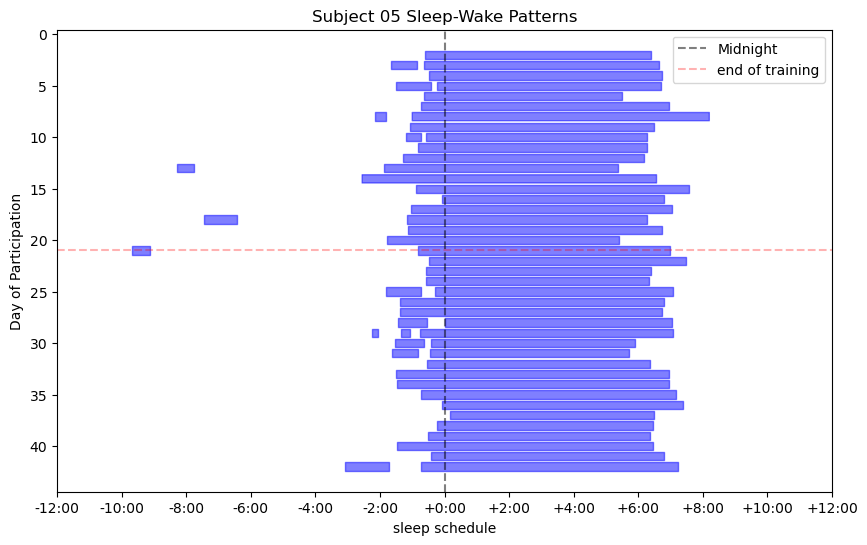

In [51]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s05_full_epoch['day_of_participation'].unique():
    day_df = s05_full_epoch[s05_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 05 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 05 sleep-wake patterns.png')

# Show the plot
plt.show()


  subject  day1  day2  SRI_score
0  ORE_05   2.0   3.0      95.49
1  ORE_05   3.0   4.0      95.49
2  ORE_05   4.0   5.0      94.86
3  ORE_05   5.0   6.0      90.49
4  ORE_05   6.0   7.0      93.40


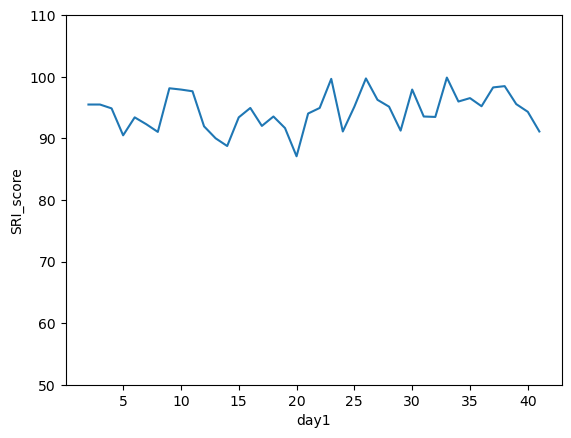

In [52]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s05_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s05_result_df_sorted = s05_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s05_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s05_result_df_sorted[s05_result_df_sorted['day_of_participation'] == day1]
    day2_df = s05_result_df_sorted[s05_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s05_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print(s05_sri_scores_df.head().round(2))


ax= sns.lineplot(data=s05_sri_scores_df, x='day1', y='SRI_score')

ax.set_yticks(np.arange(50,111,10))
plt.show()


In [53]:
##### subject 9 #########

In [54]:
s09_df= ORE_09_df.copy()

s09_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
123,ORE_09,2,2.0,TR,2022-01-28,AD,2022-01-27 23:31:00,2022-01-28 07:37:00,Sleep1,MAIN,...,NO,SLEEP_2,486.0,430.0,NaT,NaT,NaT,NaT,NaT,NaT
124,ORE_09,3,3.0,TR,2022-01-29,AD,2022-01-29 00:04:00,2022-01-29 08:22:00,Sleep1,MAIN,...,NO,SLEEP_2,498.0,448.0,NaT,NaT,NaT,NaT,NaT,NaT
125,ORE_09,4,4.0,TR,2022-01-30,AD,2022-01-30 00:24:00,2022-01-30 08:07:00,Sleep1,MAIN,...,NO,SLEEP_2,463.0,414.0,NaT,NaT,NaT,NaT,NaT,NaT
126,ORE_09,5,5.0,TR,2022-01-31,AD,2022-01-30 23:27:00,2022-01-31 07:22:00,Sleep1,MAIN,...,NO,SLEEP_2,475.0,404.0,2022-01-31 11:51:00,2022-01-31 11:59:00,NaT,NaT,NaT,NaT
127,ORE_09,6,6.0,TR,2022-02-01,AD,2022-02-01 01:39:00,2022-02-01 07:12:00,Sleep1,MAIN,...,NO,SLEEP_2,386.0,345.0,2022-01-31 12:00:00,2022-01-31 12:44:00,NaT,NaT,NaT,NaT


In [55]:
convert_multiple_sleep_epochs(s09_df)

s09_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
123,ORE_09,2,2.0,TR,2022-01-28,AD,2022-01-27 23:31:00,2022-01-28 07:37:00,Sleep1,MAIN,...,NaT,NaT,-29.0,457.0,NaN,NaN,NaN,NaN,NaN,NaN
124,ORE_09,3,3.0,TR,2022-01-29,AD,2022-01-29 00:04:00,2022-01-29 08:22:00,Sleep1,MAIN,...,NaT,NaT,4.0,502.0,NaN,NaN,NaN,NaN,NaN,NaN
125,ORE_09,4,4.0,TR,2022-01-30,AD,2022-01-30 00:24:00,2022-01-30 08:07:00,Sleep1,MAIN,...,NaT,NaT,24.0,487.0,NaN,NaN,NaN,NaN,NaN,NaN
126,ORE_09,5,5.0,TR,2022-01-31,AD,2022-01-30 23:27:00,2022-01-31 07:22:00,Sleep1,MAIN,...,NaT,NaT,-33.0,442.0,711.0,719.0,NaN,NaN,NaN,NaN
127,ORE_09,6,6.0,TR,2022-02-01,AD,2022-02-01 01:39:00,2022-02-01 07:12:00,Sleep1,MAIN,...,NaT,NaT,99.0,432.0,-720.0,-676.0,NaN,NaN,NaN,NaN


In [56]:
############ Create full epoch df ##############

s09_full_epoch= create_full_epoch_df(s09_df)

s09_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_09,2022-01-28,2.0,-720,0
1,ORE_09,2022-01-28,2.0,-719,0
2,ORE_09,2022-01-28,2.0,-718,0
3,ORE_09,2022-01-28,2.0,-717,0
4,ORE_09,2022-01-28,2.0,-716,0


In [57]:
S09_visits_to_drop = [24]

s09_full_epoch = s09_full_epoch[~s09_full_epoch['day_of_participation'].isin(S09_visits_to_drop)]

# Check unique values in 'day_of_participation' after dropping
list(s09_full_epoch['day_of_participation'].unique())


[2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0]

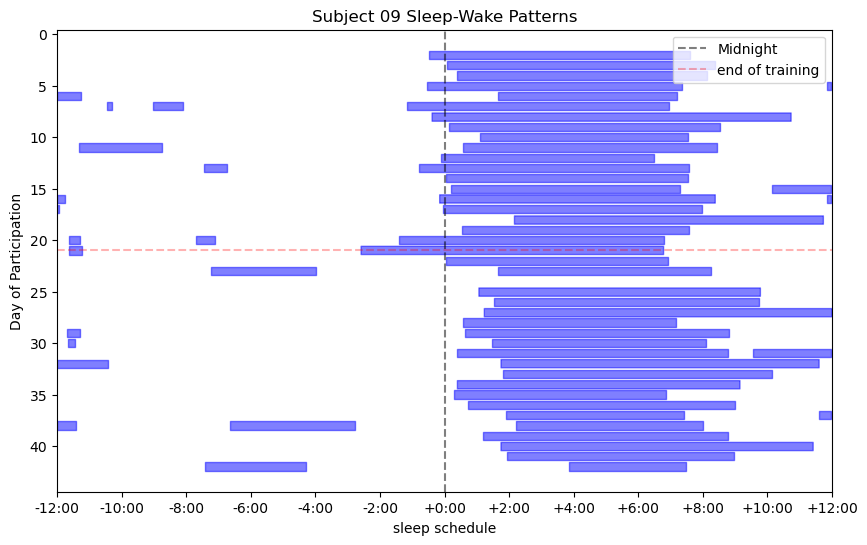

In [58]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s09_full_epoch['day_of_participation'].unique():
    day_df = s09_full_epoch[s09_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 09 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 09 sleep-wake patterns.png')

# Show the plot

plt.show()



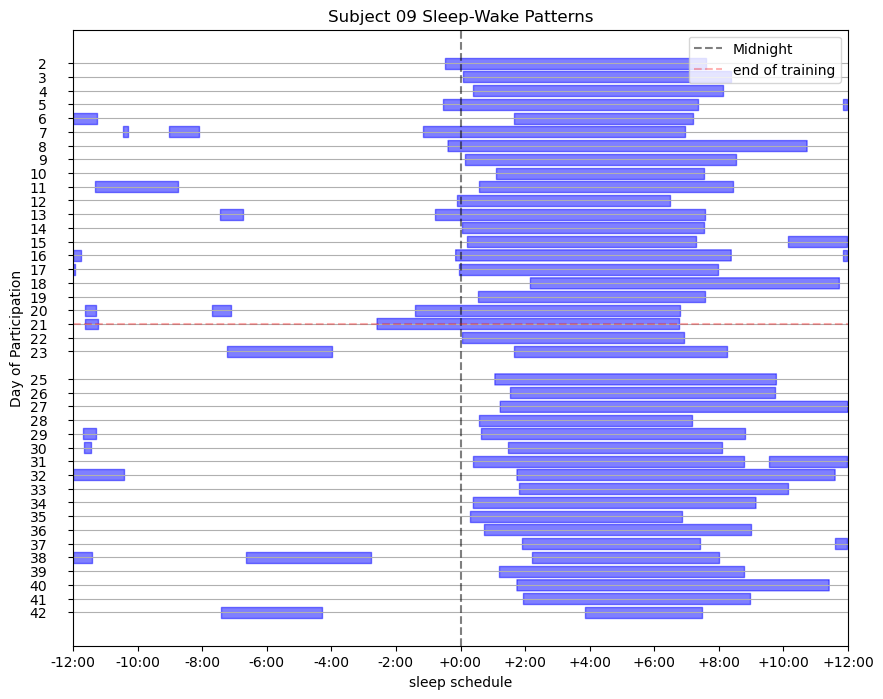

In [59]:
############ using this to ensure that subject 09's sleep data is being reported along the proper day...
############ this subject has several sleep periods occurring across the noon-noon threshold (day change)
### make sleep-wake4 pairing to move the excess sleep onto appropiate day...truncate sleep to end at noon

# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 8))

# Loop through each day of participation and plot
for day in s09_full_epoch['day_of_participation'].unique():
    day_df = s09_full_epoch[s09_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 09 Sleep-Wake Patterns")
plt.legend()

y_ticks=list(s09_full_epoch['day_of_participation'].unique())
plt.yticks(y_ticks)
plt.tick_params(axis='y', pad=15)

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
# plt.savefig('Subject 09 sleep-wake patterns.png')

# Show the plot
plt.grid(axis='y')
plt.show()



  subject  day1  day2  SRI_score
0  ORE_09   2.0   3.0      94.58
1  ORE_09   3.0   4.0      97.57
2  ORE_09   4.0   5.0      92.29
3  ORE_09   5.0   6.0      86.39
4  ORE_09   6.0   7.0      79.51


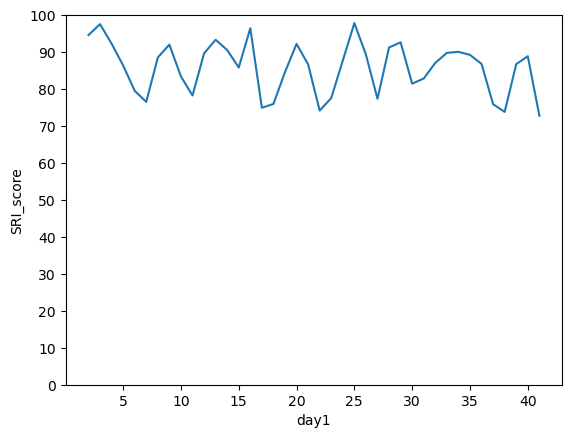

In [60]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s09_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s09_result_df_sorted = s09_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s09_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s09_result_df_sorted[s09_result_df_sorted['day_of_participation'] == day1]
    day2_df = s09_result_df_sorted[s09_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s09_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s09_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s09_sri_scores_df, x='day1', y='SRI_score')

# ax.set_yticks(np.arange(50,111,10))
ax.set_yticks(np.arange(0,101,10))

plt.show()


In [61]:
####### subject 10 ###########
s10_df= ORE_10_df.copy()

s10_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
164,ORE_10,2,2.0,TR,2022-03-25,OR,2022-03-24 23:49:00,2022-03-25 08:24:00,Sleep1,MAIN,...,NO,SLEEP_2,515.0,450.0,NaT,NaT,NaT,NaT,NaT,NaT
165,ORE_10,3,3.0,TR,2022-03-26,OR,2022-03-25 22:34:00,2022-03-26 07:49:00,Sleep1,MAIN,...,NO,SLEEP_2,555.0,493.0,NaT,NaT,NaT,NaT,NaT,NaT
166,ORE_10,4,4.0,TR,2022-03-27,OR,2022-03-26 23:19:00,2022-03-27 07:56:00,Sleep1,MAIN,...,NO,SLEEP_2,517.0,468.0,NaT,NaT,NaT,NaT,NaT,NaT
167,ORE_10,5,5.0,TR,2022-03-28,OR,2022-03-27 22:56:00,2022-03-28 05:51:00,Sleep1,MAIN,...,NO,SLEEP_2,415.0,369.0,NaT,NaT,NaT,NaT,NaT,NaT
168,ORE_10,6,6.0,TR,2022-03-29,OR,2022-03-28 23:08:00,2022-03-29 07:19:00,Sleep1,MAIN,...,NO,SLEEP_2,491.0,446.0,NaT,NaT,NaT,NaT,NaT,NaT


In [62]:
######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s10_df)

s10_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
164,ORE_10,2,2.0,TR,2022-03-25,OR,2022-03-24 23:49:00,2022-03-25 08:24:00,Sleep1,MAIN,...,NaT,NaT,-11.0,504.0,None,None,None,None,None,None
165,ORE_10,3,3.0,TR,2022-03-26,OR,2022-03-25 22:34:00,2022-03-26 07:49:00,Sleep1,MAIN,...,NaT,NaT,-86.0,469.0,None,None,None,None,None,None
166,ORE_10,4,4.0,TR,2022-03-27,OR,2022-03-26 23:19:00,2022-03-27 07:56:00,Sleep1,MAIN,...,NaT,NaT,-41.0,476.0,None,None,None,None,None,None
167,ORE_10,5,5.0,TR,2022-03-28,OR,2022-03-27 22:56:00,2022-03-28 05:51:00,Sleep1,MAIN,...,NaT,NaT,-64.0,351.0,None,None,None,None,None,None
168,ORE_10,6,6.0,TR,2022-03-29,OR,2022-03-28 23:08:00,2022-03-29 07:19:00,Sleep1,MAIN,...,NaT,NaT,-52.0,439.0,None,None,None,None,None,None


In [63]:
############ Create full epoch df ##############

s10_full_epoch= create_full_epoch_df(s10_df)

s10_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_10,2022-03-25,2.0,-720,0
1,ORE_10,2022-03-25,2.0,-719,0
2,ORE_10,2022-03-25,2.0,-718,0
3,ORE_10,2022-03-25,2.0,-717,0
4,ORE_10,2022-03-25,2.0,-716,0


In [64]:
S10_visits_to_drop = [24,25,26,27,28,29, 34, 39]

s10_full_epoch = s10_full_epoch[~s10_full_epoch['day_of_participation'].isin(S10_visits_to_drop)]

# Check unique values in 'day_of_participation' after dropping
list(s10_full_epoch['day_of_participation'].unique())


[2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 30.0,
 31.0,
 32.0,
 33.0,
 35.0,
 36.0,
 37.0,
 38.0,
 40.0,
 41.0,
 42.0]

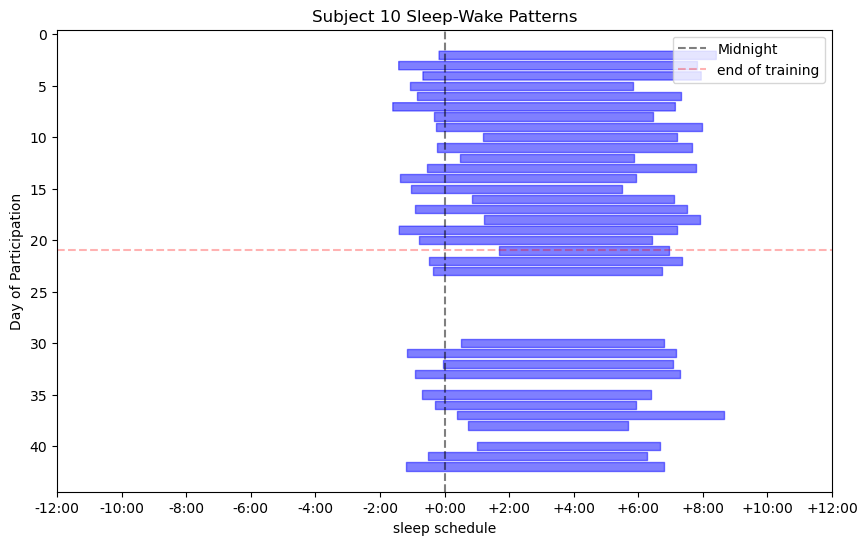

In [65]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s10_full_epoch['day_of_participation'].unique():
    day_df = s10_full_epoch[s10_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 10 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 10 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORE_10   2.0   3.0      92.36
1  ORE_10   3.0   4.0      96.39
2  ORE_10   4.0   5.0      89.72
3  ORE_10   5.0   6.0      93.06
4  ORE_10   6.0   7.0      96.11


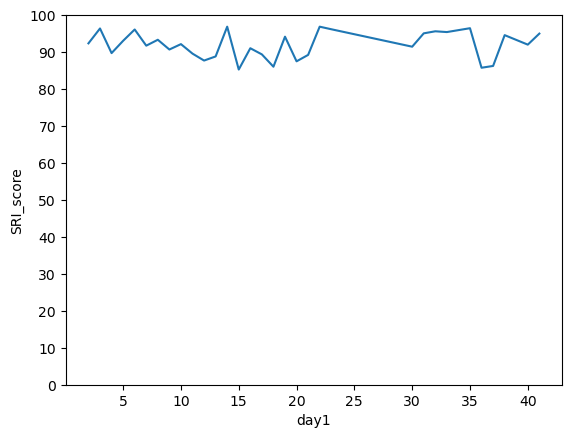

In [66]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s10_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s10_result_df_sorted = s10_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s10_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s10_result_df_sorted[s10_result_df_sorted['day_of_participation'] == day1]
    day2_df = s10_result_df_sorted[s10_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s10_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s10_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s10_sri_scores_df, x='day1', y='SRI_score')

# ax.set_yticks(np.arange(50,111,10))
ax.set_yticks(np.arange(0,101,10))
plt.show()


In [67]:
####### subject 10 ###########
s11_df= ORE_11_df.copy()

s11_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
205,ORE_11,2,2.0,TR,2022-04-01,OR,NaT,NaT,NaN,NaN,...,NO,SLEEP_2,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT
206,ORE_11,3,3.0,TR,2022-04-02,OR,2022-04-01 21:23:00,2022-04-02 06:48:00,Sleep1,MAIN,...,NO,SLEEP_2,565.0,507.0,NaT,NaT,NaT,NaT,NaT,NaT
207,ORE_11,4,4.0,TR,2022-04-03,OR,2022-04-02 22:31:00,2022-04-03 05:27:00,Sleep1,MAIN,...,NO,SLEEP_2,416.0,386.0,NaT,NaT,NaT,NaT,NaT,NaT
208,ORE_11,5,5.0,TR,2022-04-04,OR,2022-04-03 22:22:00,2022-04-04 05:10:00,Sleep1,MAIN,...,NO,SLEEP_2,536.0,502.0,2022-10-04 09:16:00,2022-10-04 11:24:00,NaT,NaT,NaT,NaT
209,ORE_11,6,6.0,TR,2022-04-05,OR,2022-04-04 21:12:00,2022-04-05 05:03:00,Sleep1,MAIN,...,NO,SLEEP_2,471.0,438.0,NaT,NaT,NaT,NaT,NaT,NaT


In [68]:
######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s11_df)

s11_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
205,ORE_11,2,2.0,TR,2022-04-01,OR,NaT,NaT,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,NaN,None,None,None,None
206,ORE_11,3,3.0,TR,2022-04-02,OR,2022-04-01 21:23:00,2022-04-02 06:48:00,Sleep1,MAIN,...,NaT,NaT,-157.0,408.0,NaN,NaN,None,None,None,None
207,ORE_11,4,4.0,TR,2022-04-03,OR,2022-04-02 22:31:00,2022-04-03 05:27:00,Sleep1,MAIN,...,NaT,NaT,-89.0,327.0,NaN,NaN,None,None,None,None
208,ORE_11,5,5.0,TR,2022-04-04,OR,2022-04-03 22:22:00,2022-04-04 05:10:00,Sleep1,MAIN,...,NaT,NaT,-98.0,310.0,556.0,684.0,None,None,None,None
209,ORE_11,6,6.0,TR,2022-04-05,OR,2022-04-04 21:12:00,2022-04-05 05:03:00,Sleep1,MAIN,...,NaT,NaT,-168.0,303.0,NaN,NaN,None,None,None,None


In [69]:
############ Create full epoch df ##############

s11_full_epoch= create_full_epoch_df(s11_df)

s11_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_11,2022-04-01,2.0,-720,0
1,ORE_11,2022-04-01,2.0,-719,0
2,ORE_11,2022-04-01,2.0,-718,0
3,ORE_11,2022-04-01,2.0,-717,0
4,ORE_11,2022-04-01,2.0,-716,0


In [70]:
S11_visits_to_drop = [2,26,27, 38, 41,42]

s11_full_epoch = s11_full_epoch[~s11_full_epoch['day_of_participation'].isin(S11_visits_to_drop)]

# Check unique values in 'day_of_participation' after dropping
list(s11_full_epoch['day_of_participation'].unique())


[3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 39.0,
 40.0]

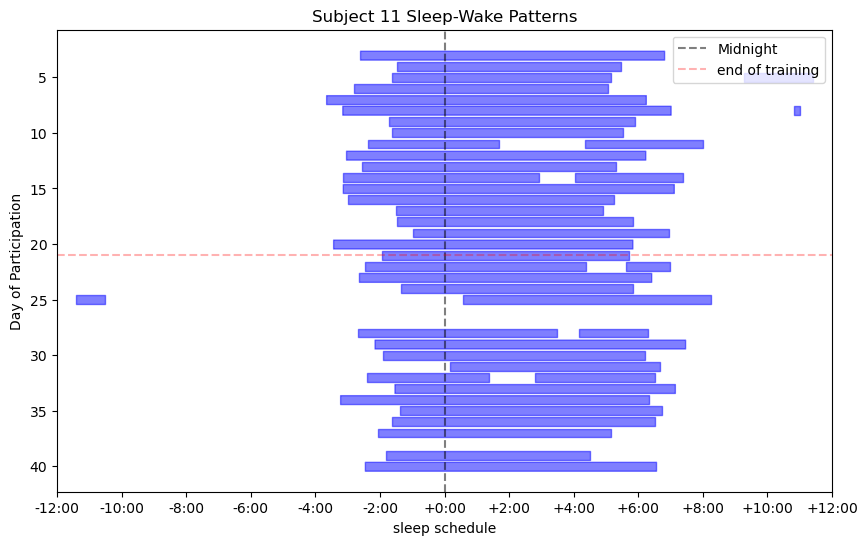

In [71]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s11_full_epoch['day_of_participation'].unique():
    day_df = s11_full_epoch[s11_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 11 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 11 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORE_11   3.0   4.0      89.65
1  ORE_11   4.0   5.0      89.24
2  ORE_11   5.0   6.0      85.69
3  ORE_11   6.0   7.0      91.46
4  ORE_11   7.0   8.0      93.75


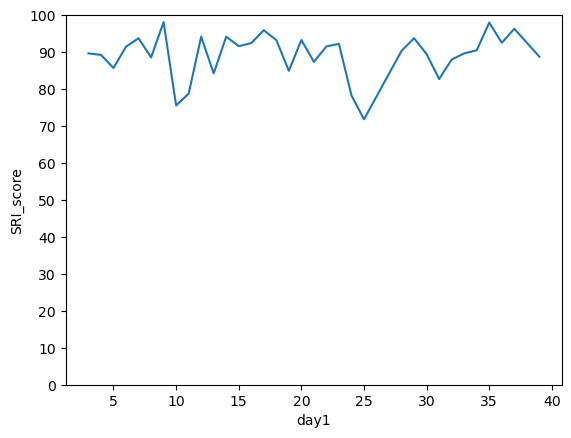

In [72]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s11_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s11_result_df_sorted = s11_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s11_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s11_result_df_sorted[s11_result_df_sorted['day_of_participation'] == day1]
    day2_df = s11_result_df_sorted[s11_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s11_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s11_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s11_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))
plt.show()


In [73]:
####### subject 18 ###########
s18_df= ORE_18_df.copy()

s18_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
246,ORE_18,2,2.0,TR,2022-09-09,AD,2022-09-08 21:01:00,2022-09-09 04:55:00,Sleep1,MAIN,...,NO,SLEEP_2,474.0,431.0,NaT,NaT,NaT,NaT,NaT,NaT
247,ORE_18,3,3.0,TR,2022-09-10,AD,2022-09-09 23:18:00,2022-09-10 05:14:00,Sleep1,MAIN,...,NO,SLEEP_2,455.0,390.0,2022-09-10 12:56:00,2022-09-10 14:35:00,NaT,NaT,NaT,NaT
248,ORE_18,4,4.0,TR,2022-09-11,AD,2022-09-10 21:03:00,2022-09-11 04:01:00,Sleep1,MAIN,...,NO,SLEEP_2,418.0,366.0,NaT,NaT,NaT,NaT,NaT,NaT
249,ORE_18,5,5.0,TR,2022-09-12,AD,2022-09-11 21:14:00,2022-09-11 23:36:00,Sleep2,NO,...,NO,SLEEP_2,403.0,355.0,2022-09-12 01:49:00,2022-09-12 06:10:00,NaT,NaT,NaT,NaT
250,ORE_18,6,6.0,TR,2022-09-13,AD,2022-09-12 22:21:00,2022-09-13 02:24:00,Sleep1,MAIN,...,NO,SLEEP_2,243.0,201.0,NaT,NaT,NaT,NaT,NaT,NaT


In [74]:
######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s18_df)

s18_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
246,ORE_18,2,2.0,TR,2022-09-09,AD,2022-09-08 21:01:00,2022-09-09 04:55:00,Sleep1,MAIN,...,NaT,NaT,-179,295,NaN,NaN,NaN,NaN,None,None
247,ORE_18,3,3.0,TR,2022-09-10,AD,2022-09-09 23:18:00,2022-09-10 05:14:00,Sleep1,MAIN,...,NaT,NaT,-42,314,776.0,875.0,NaN,NaN,None,None
248,ORE_18,4,4.0,TR,2022-09-11,AD,2022-09-10 21:03:00,2022-09-11 04:01:00,Sleep1,MAIN,...,NaT,NaT,-177,241,NaN,NaN,NaN,NaN,None,None
249,ORE_18,5,5.0,TR,2022-09-12,AD,2022-09-11 21:14:00,2022-09-11 23:36:00,Sleep2,NO,...,NaT,NaT,-166,-24,109.0,370.0,NaN,NaN,None,None
250,ORE_18,6,6.0,TR,2022-09-13,AD,2022-09-12 22:21:00,2022-09-13 02:24:00,Sleep1,MAIN,...,NaT,NaT,-99,144,NaN,NaN,NaN,NaN,None,None


In [75]:
############ Create full epoch df ##############

s18_full_epoch= create_full_epoch_df(s18_df)

s18_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_18,2022-09-09,2.0,-720,0
1,ORE_18,2022-09-09,2.0,-719,0
2,ORE_18,2022-09-09,2.0,-718,0
3,ORE_18,2022-09-09,2.0,-717,0
4,ORE_18,2022-09-09,2.0,-716,0


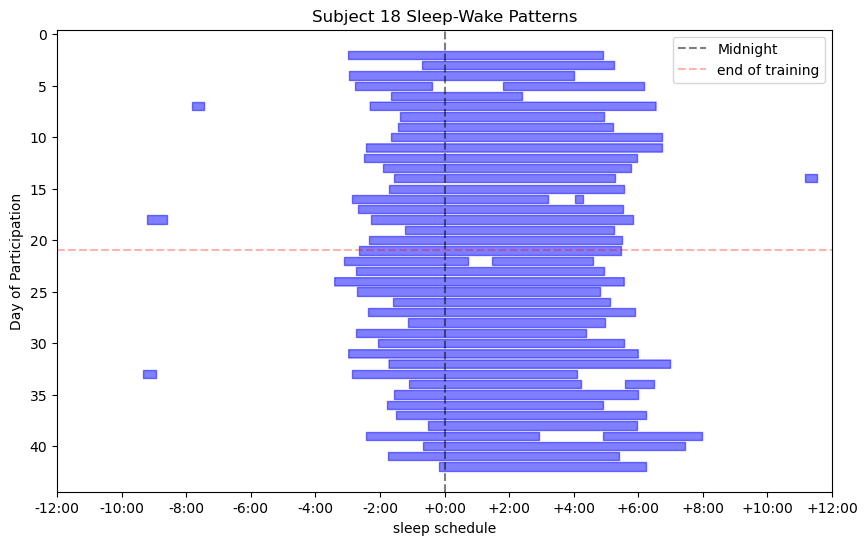

In [76]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s18_full_epoch['day_of_participation'].unique():
    day_df = s18_full_epoch[s18_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 18 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 18 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORE_18   2.0   3.0      89.17
1  ORE_18   3.0   4.0      85.56
2  ORE_18   4.0   5.0      81.11
3  ORE_18   5.0   6.0      70.49
4  ORE_18   6.0   7.0      78.40


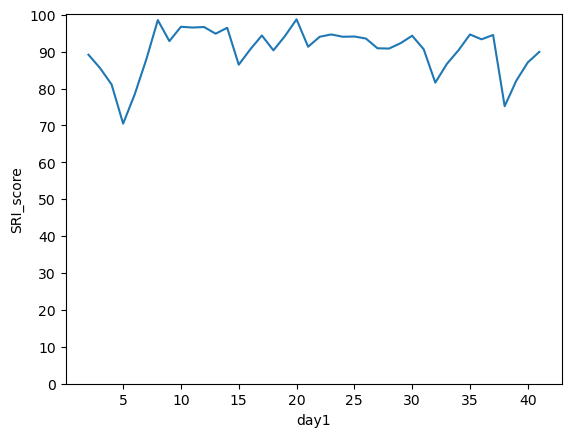

In [77]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s18_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s18_result_df_sorted = s18_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s18_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s18_result_df_sorted[s18_result_df_sorted['day_of_participation'] == day1]
    day2_df = s18_result_df_sorted[s18_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s18_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s18_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s18_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [78]:
####### subject 19 ###########
s19_df= ORE_19_df.copy()

s19_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
287,ORE_19,2,2.0,TR,2022-09-27,AD,2022-09-26 21:56:00,2022-09-27 06:02:00,Sleep1,MAIN,...,NO,SLEEP_2,486.0,456.0,NaT,NaT,NaT,NaT,NaT,NaT
288,ORE_19,3,3.0,TR,2022-09-28,AD,2022-09-27 22:45:00,2022-09-28 05:41:00,Sleep1,MAIN,...,NO,SLEEP_2,416.0,377.0,NaT,NaT,NaT,NaT,NaT,NaT
289,ORE_19,4,4.0,TR,2022-09-29,AD,2022-09-28 21:59:00,2022-09-29 05:57:00,Sleep1,MAIN,...,NO,SLEEP_2,478.0,430.0,NaT,NaT,NaT,NaT,NaT,NaT
290,ORE_19,5,5.0,TR,2022-09-30,AD,2022-09-29 21:58:00,2022-09-30 06:50:00,Sleep1,MAIN,...,NO,SLEEP_2,532.0,480.0,NaT,NaT,NaT,NaT,NaT,NaT
291,ORE_19,6,6.0,TR,2022-10-01,AD,2022-10-01 00:26:00,2022-10-01 06:46:00,Sleep1,MAIN,...,NO,SLEEP_2,380.0,351.0,NaT,NaT,NaT,NaT,NaT,NaT


In [79]:
s19_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)

In [80]:
######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s19_df)

s19_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
287,ORE_19,2,2.0,TR,2022-09-27,AD,2022-09-26 21:56:00,2022-09-27 06:02:00,Sleep1,MAIN,...,NaT,NaT,-124,362,None,None,None,None,None,None
288,ORE_19,3,3.0,TR,2022-09-28,AD,2022-09-27 22:45:00,2022-09-28 05:41:00,Sleep1,MAIN,...,NaT,NaT,-75,341,None,None,None,None,None,None
289,ORE_19,4,4.0,TR,2022-09-29,AD,2022-09-28 21:59:00,2022-09-29 05:57:00,Sleep1,MAIN,...,NaT,NaT,-121,357,None,None,None,None,None,None
290,ORE_19,5,5.0,TR,2022-09-30,AD,2022-09-29 21:58:00,2022-09-30 06:50:00,Sleep1,MAIN,...,NaT,NaT,-122,410,None,None,None,None,None,None
291,ORE_19,6,6.0,TR,2022-10-01,AD,2022-10-01 00:26:00,2022-10-01 06:46:00,Sleep1,MAIN,...,NaT,NaT,26,406,None,None,None,None,None,None


In [81]:
############ Create full epoch df ##############

s19_full_epoch= create_full_epoch_df(s19_df)

s19_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_19,2022-09-27,2.0,-720,0
1,ORE_19,2022-09-27,2.0,-719,0
2,ORE_19,2022-09-27,2.0,-718,0
3,ORE_19,2022-09-27,2.0,-717,0
4,ORE_19,2022-09-27,2.0,-716,0


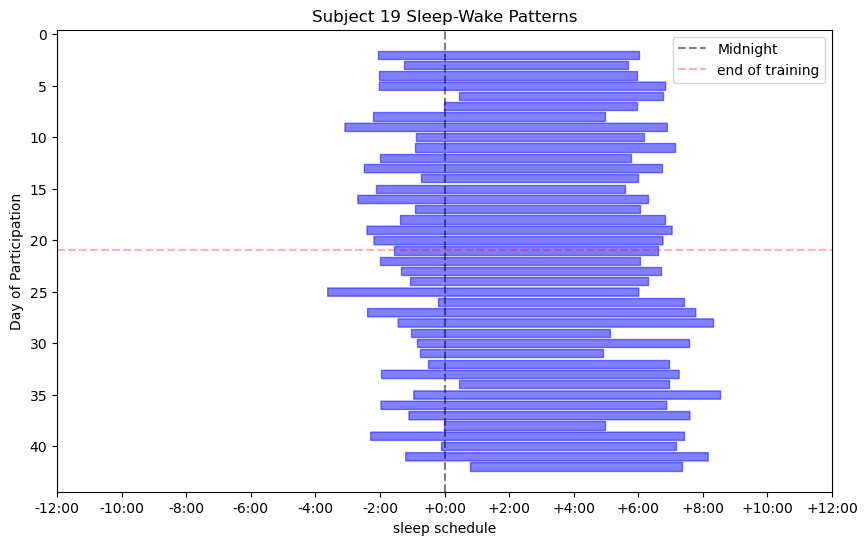

In [82]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s19_full_epoch['day_of_participation'].unique():
    day_df = s19_full_epoch[s19_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 19 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 19 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORE_19   2.0   3.0      95.14
1  ORE_19   3.0   4.0      95.69
2  ORE_19   4.0   5.0      96.25
3  ORE_19   5.0   6.0      89.44
4  ORE_19   6.0   7.0      94.79


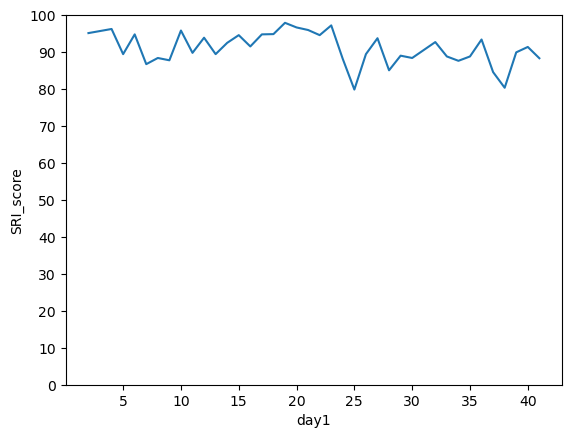

In [83]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s19_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s19_result_df_sorted = s19_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s19_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s19_result_df_sorted[s19_result_df_sorted['day_of_participation'] == day1]
    day2_df = s19_result_df_sorted[s19_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s19_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s19_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s19_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [84]:
####### subject 23 ###########
s23_df= ORE_23_df.copy()
s23_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s23_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
328,ORE_23,2,2.0,TR,2023-01-06,AD,2023-01-06 00:12:00,2023-01-06 05:30:00,Sleep1,MAIN,...,NO,SLEEP_2,318.0,303.0,NaT,NaT,NaT,NaT,NaT,NaT
329,ORE_23,3,3.0,TR,2023-01-07,AD,2023-01-06 21:04:00,2023-01-07 06:07:00,Sleep1,MAIN,...,NO,SLEEP_2,543.0,489.0,NaT,NaT,NaT,NaT,NaT,NaT
330,ORE_23,4,4.0,TR,2023-01-08,AD,2023-01-07 23:09:00,2023-01-08 06:36:00,Sleep1,MAIN,...,NO,SLEEP_2,447.0,410.0,NaT,NaT,NaT,NaT,NaT,NaT
331,ORE_23,5,5.0,TR,2023-01-09,AD,2023-01-08 23:57:00,2023-01-09 05:18:00,Sleep1,MAIN,...,NO,SLEEP_2,321.0,321.0,NaT,NaT,NaT,NaT,NaT,NaT
332,ORE_23,6,6.0,TR,2023-01-10,AD,2023-01-09 23:48:00,2023-01-10 06:14:00,Sleep1,MAIN,...,NO,SLEEP_2,386.0,358.0,NaT,NaT,NaT,NaT,NaT,NaT


In [85]:
s23_df['sleep1_date_time24'].isna().sum()

0

In [86]:
######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s23_df)

s23_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep4_date_time24,wake4_date_time24,sleep1_epoch,wake1_epoch,sleep2_epoch,wake2_epoch,sleep3_epoch,wake3_epoch,sleep4_epoch,wake4_epoch
328,ORE_23,2,2.0,TR,2023-01-06,AD,2023-01-06 00:12:00,2023-01-06 05:30:00,Sleep1,MAIN,...,NaT,NaT,12,330,None,None,None,None,None,None
329,ORE_23,3,3.0,TR,2023-01-07,AD,2023-01-06 21:04:00,2023-01-07 06:07:00,Sleep1,MAIN,...,NaT,NaT,-176,367,None,None,None,None,None,None
330,ORE_23,4,4.0,TR,2023-01-08,AD,2023-01-07 23:09:00,2023-01-08 06:36:00,Sleep1,MAIN,...,NaT,NaT,-51,396,None,None,None,None,None,None
331,ORE_23,5,5.0,TR,2023-01-09,AD,2023-01-08 23:57:00,2023-01-09 05:18:00,Sleep1,MAIN,...,NaT,NaT,-3,318,None,None,None,None,None,None
332,ORE_23,6,6.0,TR,2023-01-10,AD,2023-01-09 23:48:00,2023-01-10 06:14:00,Sleep1,MAIN,...,NaT,NaT,-12,374,None,None,None,None,None,None


In [87]:
############ Create full epoch df ##############

s23_full_epoch= create_full_epoch_df(s23_df)

s23_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_23,2023-01-06,2.0,-720,0
1,ORE_23,2023-01-06,2.0,-719,0
2,ORE_23,2023-01-06,2.0,-718,0
3,ORE_23,2023-01-06,2.0,-717,0
4,ORE_23,2023-01-06,2.0,-716,0


In [88]:
S23_visits_to_drop = [25]

s23_full_epoch = s23_full_epoch[~s23_full_epoch['day_of_participation'].isin(S23_visits_to_drop)]

# Check unique values in 'day_of_participation' after dropping
list(s23_full_epoch['day_of_participation'].unique())


[2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0]

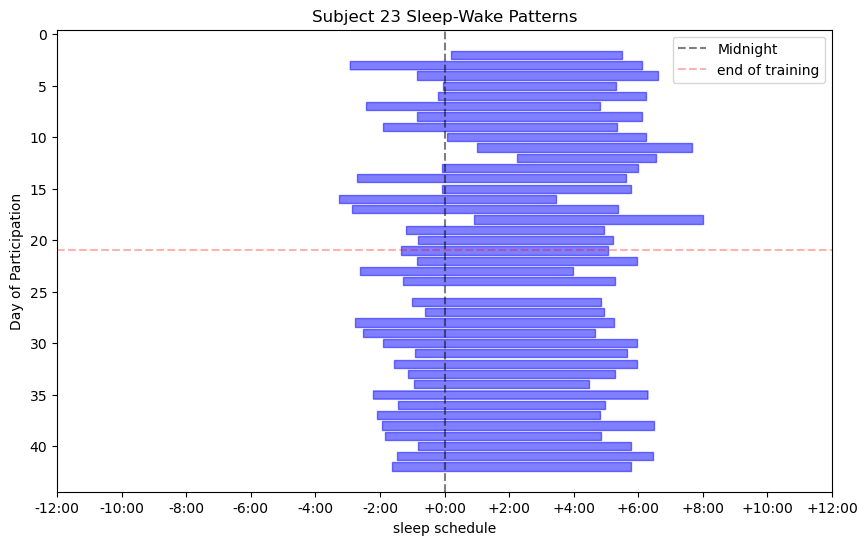

In [89]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s23_full_epoch['day_of_participation'].unique():
    day_df = s23_full_epoch[s23_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 23 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 23 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORE_23   2.0   3.0      84.38
1  ORE_23   3.0   4.0      89.31
2  ORE_23   4.0   5.0      91.25
3  ORE_23   5.0   6.0      95.49
4  ORE_23   6.0   7.0      84.72


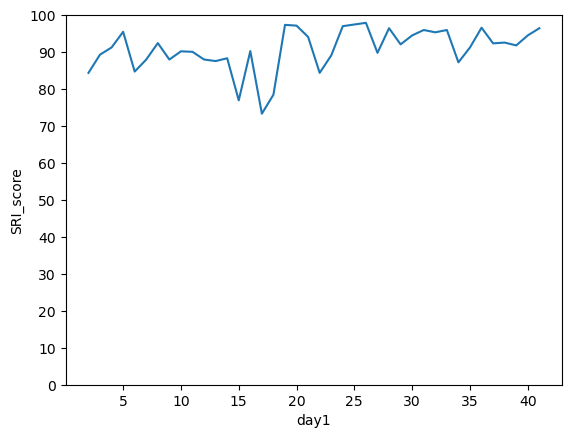

In [90]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s23_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s23_result_df_sorted = s23_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s23_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s23_result_df_sorted[s23_result_df_sorted['day_of_participation'] == day1]
    day2_df = s23_result_df_sorted[s23_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s23_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s23_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s23_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [91]:
####### subject 24 ###########
s24_df= ORE_24_df.copy()

s24_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
369,ORE_24,2,2.0,TR,2023-01-06,AD,2023-01-06 00:54:00,2023-01-06 07:21:00,Sleep1,MAIN,...,NO,SLEEP_2,387.0,362.0,NaT,NaT,NaT,NaT,NaT,NaT
370,ORE_24,3,3.0,TR,2023-01-07,AD,2023-01-07 02:20:00,2023-01-07 10:00:00,Sleep1,MAIN,...,NO,SLEEP_2,460.0,428.0,NaT,NaT,NaT,NaT,NaT,NaT
371,ORE_24,4,4.0,TR,2023-01-08,AD,2023-01-08 03:50:00,2023-01-08 08:58:00,Sleep1,MAIN,...,NO,SLEEP_2,308.0,291.0,NaT,NaT,NaT,NaT,NaT,NaT
372,ORE_24,5,5.0,TR,2023-01-09,AD,2023-01-09 02:32:00,2023-01-09 07:54:00,Sleep1,MAIN,...,NO,SLEEP_2,322.0,304.0,NaT,NaT,NaT,NaT,NaT,NaT
373,ORE_24,6,6.0,TR,2023-01-10,AD,2023-01-10 00:39:00,2023-01-10 06:59:00,Sleep1,MAIN,...,NO,SLEEP_2,380.0,355.0,NaT,NaT,NaT,NaT,NaT,NaT


In [92]:
####### subject 24 ###########
s24_df= ORE_24_df.copy()
s24_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)

s24_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
369,ORE_24,2,2.0,TR,2023-01-06,AD,2023-01-06 00:54:00,2023-01-06 07:21:00,Sleep1,MAIN,...,NO,SLEEP_2,387.0,362.0,NaT,NaT,NaT,NaT,NaT,NaT
370,ORE_24,3,3.0,TR,2023-01-07,AD,2023-01-07 02:20:00,2023-01-07 10:00:00,Sleep1,MAIN,...,NO,SLEEP_2,460.0,428.0,NaT,NaT,NaT,NaT,NaT,NaT
371,ORE_24,4,4.0,TR,2023-01-08,AD,2023-01-08 03:50:00,2023-01-08 08:58:00,Sleep1,MAIN,...,NO,SLEEP_2,308.0,291.0,NaT,NaT,NaT,NaT,NaT,NaT
372,ORE_24,5,5.0,TR,2023-01-09,AD,2023-01-09 02:32:00,2023-01-09 07:54:00,Sleep1,MAIN,...,NO,SLEEP_2,322.0,304.0,NaT,NaT,NaT,NaT,NaT,NaT
373,ORE_24,6,6.0,TR,2023-01-10,AD,2023-01-10 00:39:00,2023-01-10 06:59:00,Sleep1,MAIN,...,NO,SLEEP_2,380.0,355.0,NaT,NaT,NaT,NaT,NaT,NaT


In [93]:
######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s24_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s24_full_epoch= create_full_epoch_df(s24_df)

s24_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_24,2023-01-06,2.0,-720,0
1,ORE_24,2023-01-06,2.0,-719,0
2,ORE_24,2023-01-06,2.0,-718,0
3,ORE_24,2023-01-06,2.0,-717,0
4,ORE_24,2023-01-06,2.0,-716,0


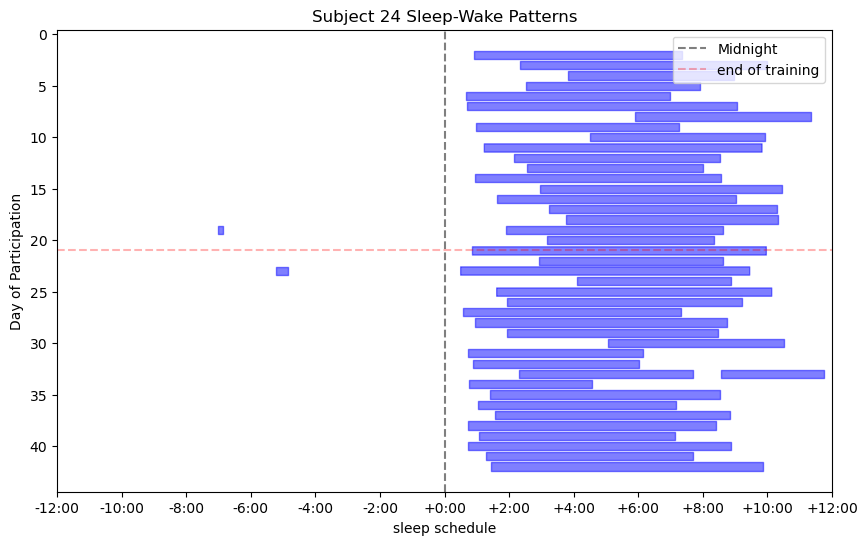

In [94]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s24_full_epoch['day_of_participation'].unique():
    day_df = s24_full_epoch[s24_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 24 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 24 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORE_24   2.0   3.0      82.99
1  ORE_24   3.0   4.0      89.44
2  ORE_24   4.0   5.0      90.14
3  ORE_24   5.0   6.0      88.33
4  ORE_24   6.0   7.0      91.11


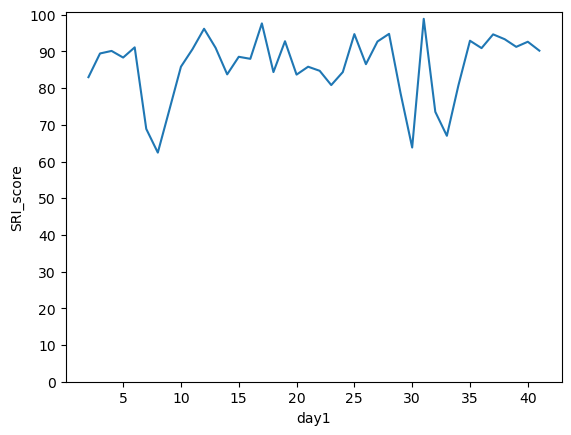

In [95]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s24_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s24_result_df_sorted = s24_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s24_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s24_result_df_sorted[s24_result_df_sorted['day_of_participation'] == day1]
    day2_df = s24_result_df_sorted[s24_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s24_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s24_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s24_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [96]:
####### subject 25 ###########
s25_df= ORE_25_df.copy()
s25_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)

s25_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
411,ORE_25,3,3.0,TR,2023-02-04,AD,2023-02-03 22:55:00,2023-02-04 06:49:00,Sleep1,MAIN,...,NO,SLEEP_2,474.0,438.0,NaT,NaT,NaT,NaT,NaT,NaT
412,ORE_25,4,4.0,TR,2023-02-05,AD,2023-02-04 23:36:00,2023-02-05 07:00:00,Sleep1,MAIN,...,NO,SLEEP_2,444.0,405.0,NaT,NaT,NaT,NaT,NaT,NaT
413,ORE_25,5,5.0,TR,2023-02-06,AD,2023-02-05 23:47:00,2023-02-06 05:34:00,Sleep1,MAIN,...,NO,SLEEP_2,347.0,329.0,NaT,NaT,NaT,NaT,NaT,NaT
414,ORE_25,6,6.0,TR,2023-02-07,AD,2023-02-06 23:58:00,2023-02-07 06:59:00,Sleep1,MAIN,...,NO,SLEEP_2,421.0,402.0,NaT,NaT,NaT,NaT,NaT,NaT
415,ORE_25,7,7.0,TR,2023-02-08,AD,2023-02-08 00:03:00,2023-02-08 06:17:00,Sleep1,MAIN,...,NO,SLEEP_2,374.0,355.0,NaT,NaT,NaT,NaT,NaT,NaT


In [97]:
######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s25_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s25_full_epoch= create_full_epoch_df(s25_df)

s25_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_25,2023-02-04,3.0,-720,0
1,ORE_25,2023-02-04,3.0,-719,0
2,ORE_25,2023-02-04,3.0,-718,0
3,ORE_25,2023-02-04,3.0,-717,0
4,ORE_25,2023-02-04,3.0,-716,0


In [98]:
S25_visits_to_drop = [2,24]

s25_full_epoch = s25_full_epoch[~s25_full_epoch['day_of_participation'].isin(S25_visits_to_drop)]

# Check unique values in 'day_of_participation' after dropping
list(s25_full_epoch['day_of_participation'].unique())


[3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0]

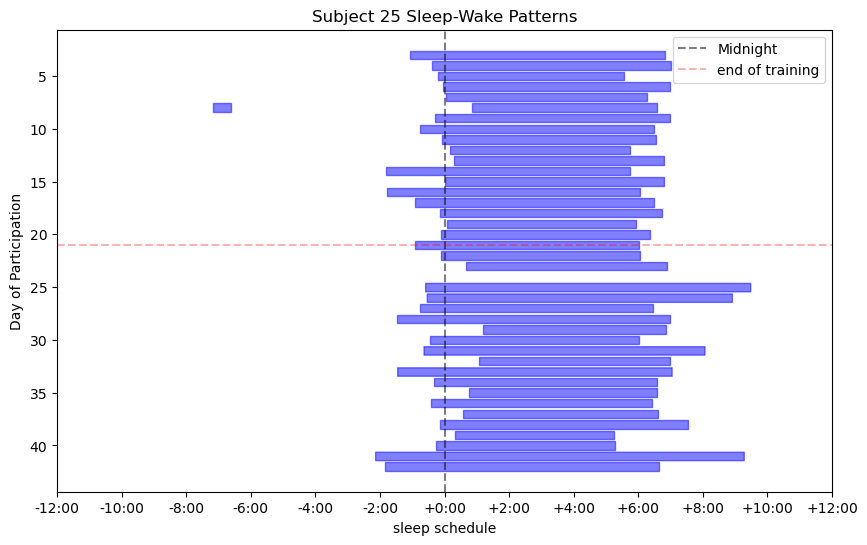

In [99]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s25_full_epoch['day_of_participation'].unique():
    day_df = s25_full_epoch[s25_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 25 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 25 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORE_25   3.0   4.0      96.39
1  ORE_25   4.0   5.0      93.26
2  ORE_25   5.0   6.0      93.33
3  ORE_25   6.0   7.0      96.74
4  ORE_25   7.0   8.0      93.12


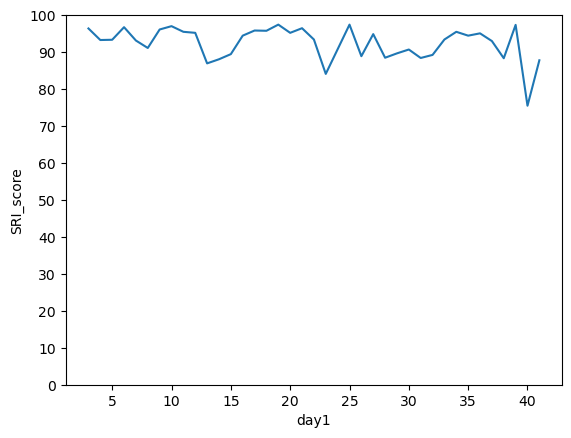

In [100]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s25_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s25_result_df_sorted = s25_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s25_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s25_result_df_sorted[s25_result_df_sorted['day_of_participation'] == day1]
    day2_df = s25_result_df_sorted[s25_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s25_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s25_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s25_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


# Control Data Starts here

In [102]:
####### subject 25 ###########
s02_df= ORC_02_df.copy()
s02_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s02_df.dropna(subset='visit_date', axis=0, inplace=True)
s02_df.head()

,subject,visit,day_of_participation,train_cat,visit_date,ot_status,sleep1_date_time24,wake1_date_time24,main_sleep,sleep1_sleep2_main,...,sleep3_main,sleep2_sleep3_main,sleep_duration24,tst_24,sleep2_date_time24,wake2_date_time24,sleep3_date_time24,wake3_date_time24,sleep4_date_time24,wake4_date_time24
453,ORC_02,4,4.0,CON,2021-06-25,CON,2021-06-24 14:00:00,2021-06-24 14:37:00,Sleep2,NO,...,NO,SLEEP_2,494.0,462.0,2021-06-24 23:00:00,2021-06-25 06:37:00,NaT,NaT,2021-06-25 11:56:00,2021-06-25 11:59:00
454,ORC_02,5,5.0,CON,2021-06-26,CON,2021-06-25 12:00:00,2021-06-25 12:31:00,Sleep2,NO,...,NO,SLEEP_2,468.0,431.0,2021-06-25 23:59:00,2021-06-26 07:12:00,NaT,NaT,NaT,NaT
455,ORC_02,6,6.0,CON,2021-06-27,CON,2021-06-26 23:04:00,2021-06-27 05:57:00,Sleep1,MAIN,...,NO,SLEEP_2,413.0,381.0,NaT,NaT,NaT,NaT,NaT,NaT
456,ORC_02,7,7.0,CON,2021-06-28,CON,2021-06-27 21:25:00,2021-06-28 05:49:00,Sleep1,MAIN,...,NO,SLEEP_2,504.0,469.0,NaT,NaT,NaT,NaT,NaT,NaT
457,ORC_02,rest1,8.0,CON,2021-06-29,CON,2021-06-28 21:45:00,2021-06-29 05:53:00,Sleep1,MAIN,...,NO,SLEEP_2,488.0,451.0,NaT,NaT,NaT,NaT,NaT,NaT


In [103]:
######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s02_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s02_full_epoch= create_full_epoch_df(s02_df)

s02_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_02,2021-06-25,4.0,-720,0
1,ORC_02,2021-06-25,4.0,-719,0
2,ORC_02,2021-06-25,4.0,-718,0
3,ORC_02,2021-06-25,4.0,-717,0
4,ORC_02,2021-06-25,4.0,-716,0


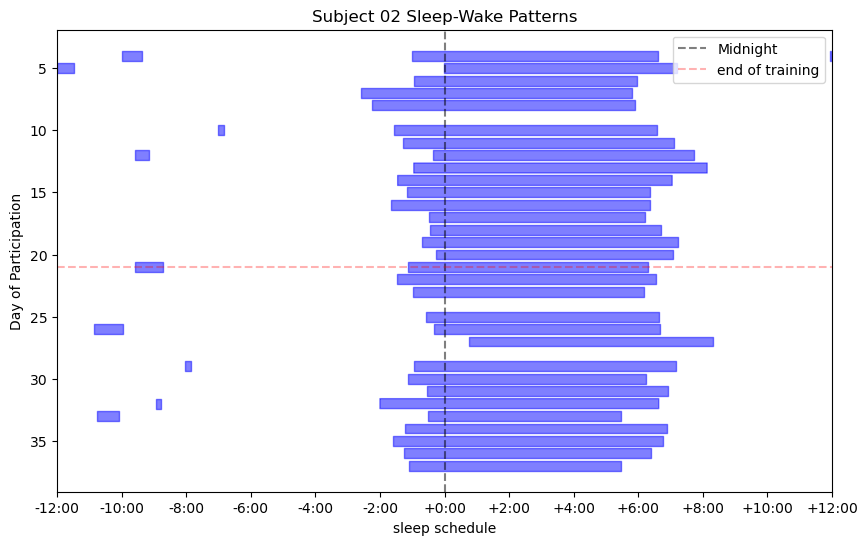

In [104]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s02_full_epoch['day_of_participation'].unique():
    day_df = s02_full_epoch[s02_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 02 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 02 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORC_02   4.0   5.0      88.33
1  ORC_02   5.0   6.0      88.75
2  ORC_02   6.0   7.0      92.57
3  ORC_02   7.0   8.0      98.33
4  ORC_02   8.0  10.0      93.47


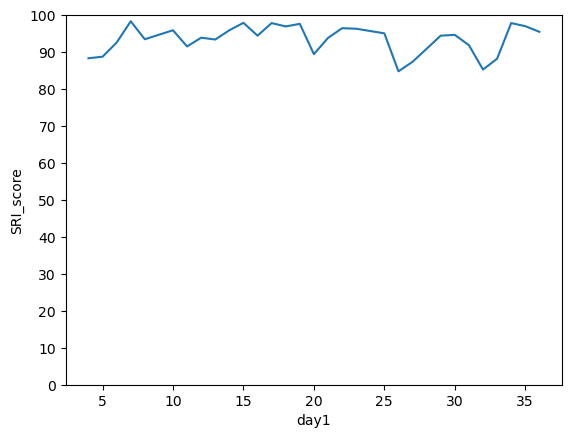

In [105]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s02_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s02_result_df_sorted = s02_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s02_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s02_result_df_sorted[s02_result_df_sorted['day_of_participation'] == day1]
    day2_df = s02_result_df_sorted[s02_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s02_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s02_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s02_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [106]:
####### subject 04 ###########
s04_df= ORC_04_df.copy()
s04_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s04_df.dropna(subset='visit_date', axis=0, inplace=True)

s04_df.head()

######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s04_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s04_full_epoch= create_full_epoch_df(s04_df)

s04_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_04,2021-09-18,3.0,-720,0
1,ORC_04,2021-09-18,3.0,-719,0
2,ORC_04,2021-09-18,3.0,-718,0
3,ORC_04,2021-09-18,3.0,-717,0
4,ORC_04,2021-09-18,3.0,-716,0


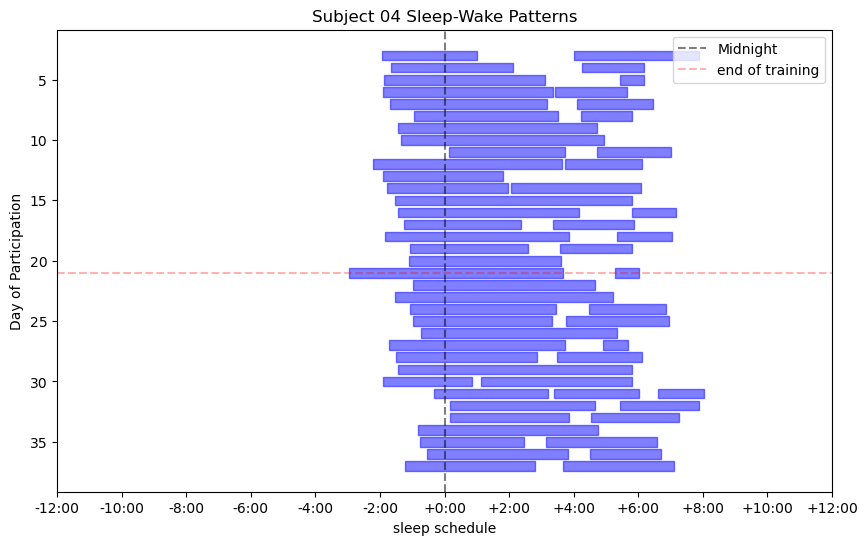

In [107]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s04_full_epoch['day_of_participation'].unique():
    day_df = s04_full_epoch[s04_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 04 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 04 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORC_04   3.0   4.0      85.90
1  ORC_04   4.0   5.0      90.14
2  ORC_04   5.0   6.0      88.33
3  ORC_04   6.0   7.0      92.22
4  ORC_04   7.0   8.0      92.22


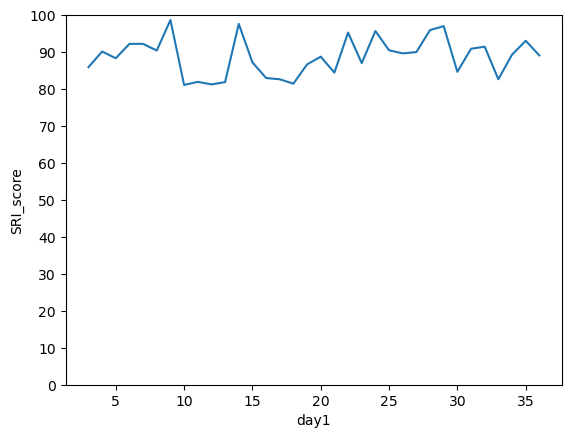

In [108]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s04_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s04_result_df_sorted = s04_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s04_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s04_result_df_sorted[s04_result_df_sorted['day_of_participation'] == day1]
    day2_df = s04_result_df_sorted[s04_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s04_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s04_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s04_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [109]:
####### subject 06 ###########
s06_df= ORC_06_df.copy()
s06_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s06_df.dropna(subset='visit_date', axis=0, inplace=True)

s06_df.head()

######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s06_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s06_full_epoch= create_full_epoch_df(s06_df)

s06_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_06,2021-10-09,3.0,-720,0
1,ORC_06,2021-10-09,3.0,-719,0
2,ORC_06,2021-10-09,3.0,-718,0
3,ORC_06,2021-10-09,3.0,-717,0
4,ORC_06,2021-10-09,3.0,-716,0


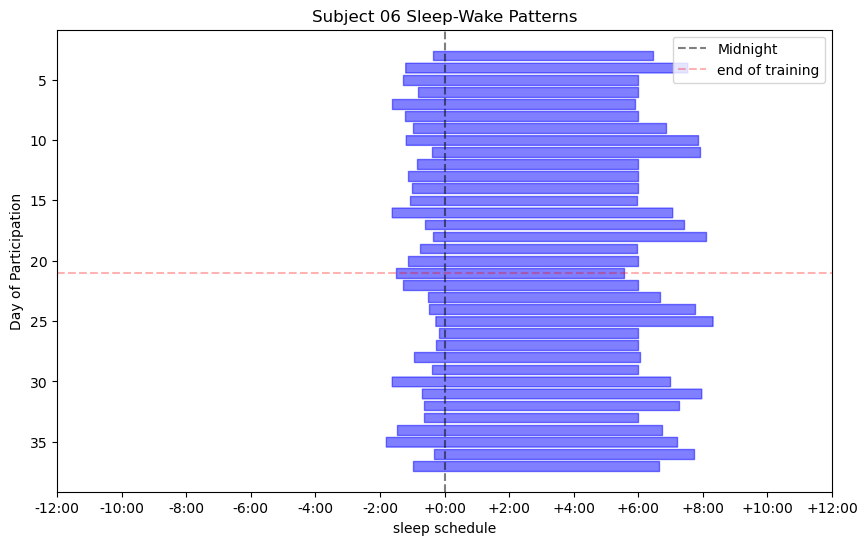

In [110]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s06_full_epoch['day_of_participation'].unique():
    day_df = s06_full_epoch[s06_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 06 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 06 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORC_06   3.0   4.0      91.94
1  ORC_06   4.0   5.0      93.33
2  ORC_06   5.0   6.0      97.99
3  ORC_06   6.0   7.0      96.32
4  ORC_06   7.0   8.0      97.92


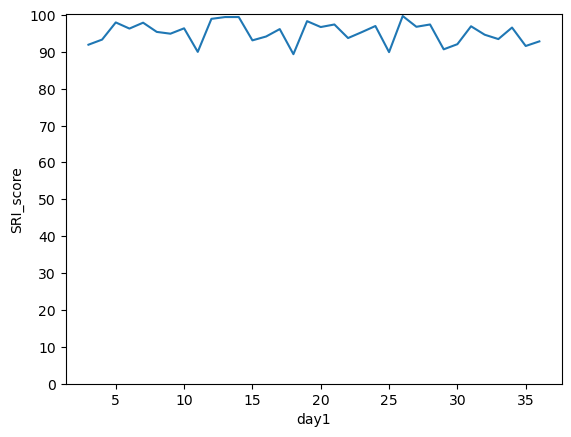

In [111]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s06_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s06_result_df_sorted = s06_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s06_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s06_result_df_sorted[s06_result_df_sorted['day_of_participation'] == day1]
    day2_df = s06_result_df_sorted[s06_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s06_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s06_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s06_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [112]:
####### subject 06 ###########
s12_df= ORC_12_df.copy()
s12_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s12_df.dropna(subset='visit_date', axis=0, inplace=True)

s12_df.head()

######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s12_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s12_full_epoch= create_full_epoch_df(s12_df)

s12_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_12,2022-03-22,2.0,-720,0
1,ORC_12,2022-03-22,2.0,-719,0
2,ORC_12,2022-03-22,2.0,-718,0
3,ORC_12,2022-03-22,2.0,-717,0
4,ORC_12,2022-03-22,2.0,-716,0


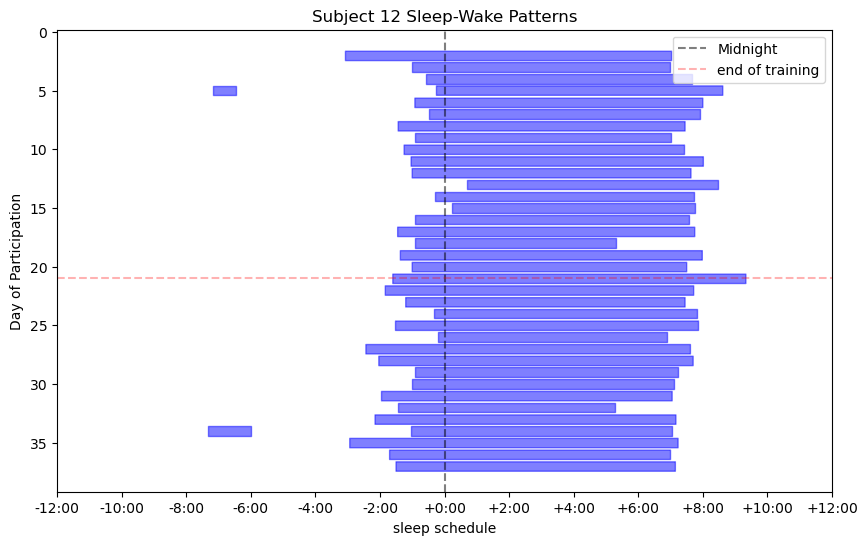

In [113]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s12_full_epoch['day_of_participation'].unique():
    day_df = s12_full_epoch[s12_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 12 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 12 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORC_12   2.0   3.0      91.18
1  ORC_12   3.0   4.0      95.35
2  ORC_12   4.0   5.0      91.67
3  ORC_12   5.0   6.0      91.46
4  ORC_12   6.0   7.0      97.78


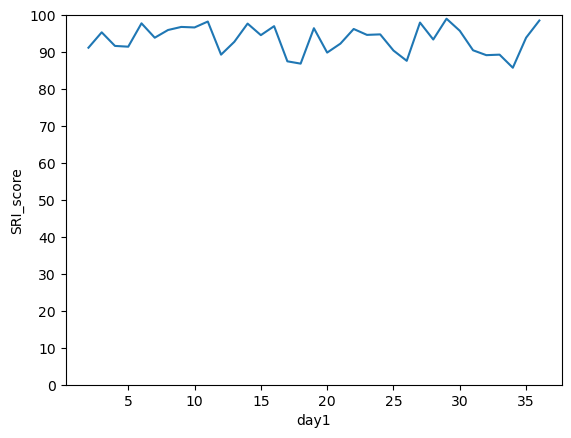

In [114]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s12_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s12_result_df_sorted = s12_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s12_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s12_result_df_sorted[s12_result_df_sorted['day_of_participation'] == day1]
    day2_df = s12_result_df_sorted[s12_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s12_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s12_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s12_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [115]:
####### subject 06 ###########
s15_df= ORC_15_df.copy()
s15_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s15_df.dropna(subset='visit_date', axis=0, inplace=True)

s15_df.head()

######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s15_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s15_full_epoch= create_full_epoch_df(s15_df)

s15_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_15,2022-07-28,4.0,-720,0
1,ORC_15,2022-07-28,4.0,-719,0
2,ORC_15,2022-07-28,4.0,-718,0
3,ORC_15,2022-07-28,4.0,-717,0
4,ORC_15,2022-07-28,4.0,-716,0


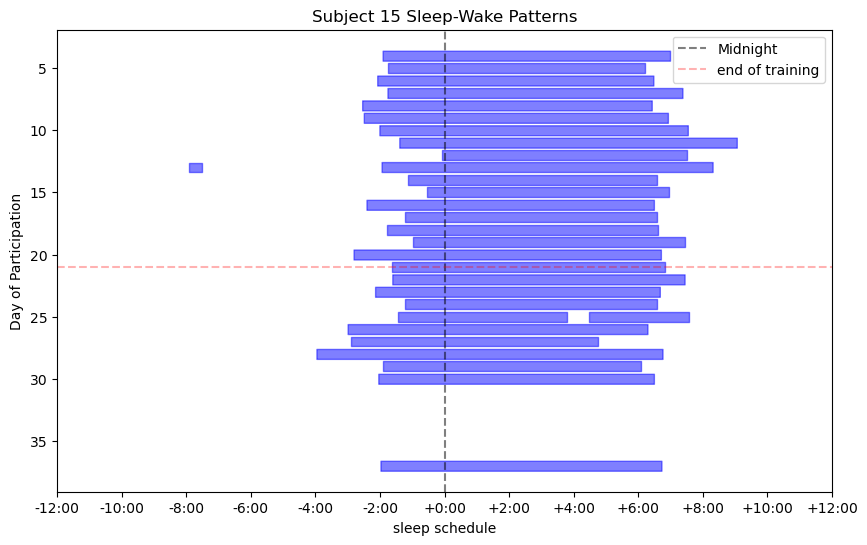

In [116]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s15_full_epoch['day_of_participation'].unique():
    day_df = s15_full_epoch[s15_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 15 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 15 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORC_15   4.0   5.0      96.04
1  ORC_15   5.0   6.0      97.50
2  ORC_15   6.0   7.0      94.93
3  ORC_15   7.0   8.0      92.78
4  ORC_15   8.0   9.0      97.71


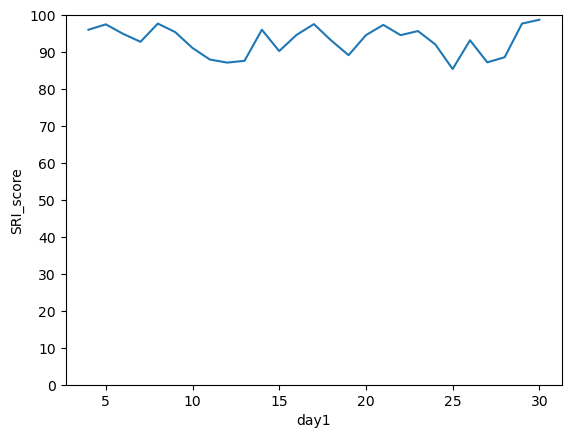

In [117]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s15_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s15_result_df_sorted = s15_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s15_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s15_result_df_sorted[s15_result_df_sorted['day_of_participation'] == day1]
    day2_df = s15_result_df_sorted[s15_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s15_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s15_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s15_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [118]:
####### subject 06 ###########
s20_df= ORC_20_df.copy()
s20_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s20_df.dropna(subset='visit_date', axis=0, inplace=True)

s20_df.head()

######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s20_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s20_full_epoch= create_full_epoch_df(s20_df)

s20_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_20,2022-10-04,2.0,-720,0
1,ORC_20,2022-10-04,2.0,-719,0
2,ORC_20,2022-10-04,2.0,-718,0
3,ORC_20,2022-10-04,2.0,-717,0
4,ORC_20,2022-10-04,2.0,-716,0


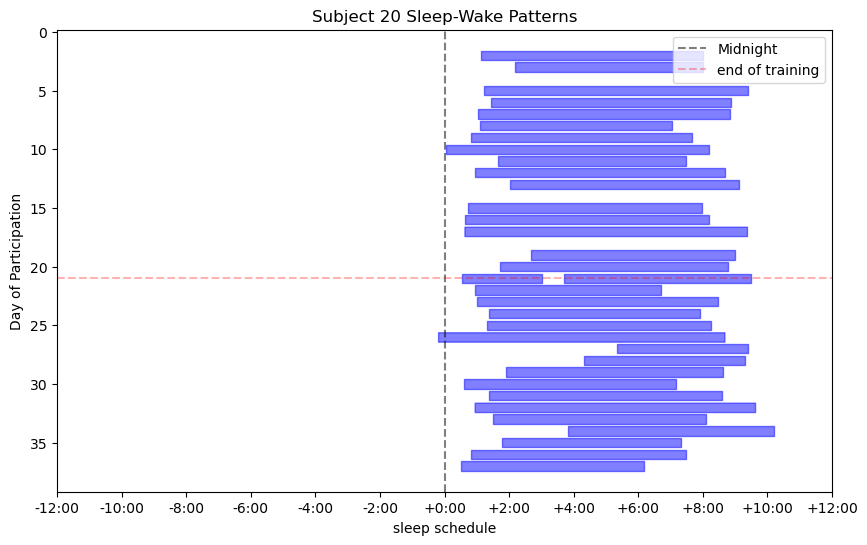

In [119]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s20_full_epoch['day_of_participation'].unique():
    day_df = s20_full_epoch[s20_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 20 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 20 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORC_20   2.0   3.0      95.62
1  ORC_20   3.0   5.0      90.28
2  ORC_20   5.0   6.0      97.01
3  ORC_20   6.0   7.0      98.12
4  ORC_20   7.0   8.0      92.36


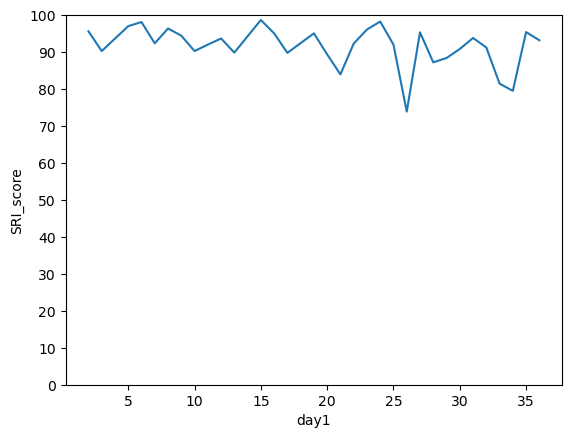

In [120]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s20_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s20_result_df_sorted = s20_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s20_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s20_result_df_sorted[s20_result_df_sorted['day_of_participation'] == day1]
    day2_df = s20_result_df_sorted[s20_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s20_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s20_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s20_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [121]:
####### subject 06 ###########
s21_df= ORC_21_df.copy()
s21_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s21_df.dropna(subset='visit_date', axis=0, inplace=True)

s21_df.head()

######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s21_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s21_full_epoch= create_full_epoch_df(s21_df)

s21_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_21,2022-10-12,2.0,-720,0
1,ORC_21,2022-10-12,2.0,-719,0
2,ORC_21,2022-10-12,2.0,-718,0
3,ORC_21,2022-10-12,2.0,-717,0
4,ORC_21,2022-10-12,2.0,-716,0


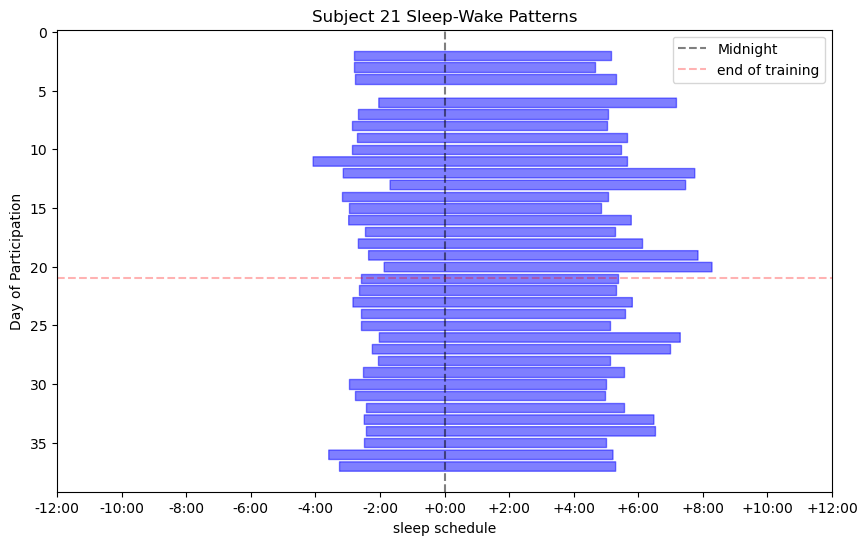

In [122]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s21_full_epoch['day_of_participation'].unique():
    day_df = s21_full_epoch[s21_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 21 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 21 sleep-wake patterns.png')

# Show the plot
plt.show()


### the gap at day 24 corresponds to the participant changing the schedule and coming in a day early...remove DoP #24 (rec3)

  subject  day1  day2  SRI_score
0  ORC_21   2.0   3.0      97.99
1  ORC_21   3.0   4.0      97.22
2  ORC_21   4.0   6.0      89.24
3  ORC_21   6.0   7.0      88.54
4  ORC_21   7.0   8.0      99.17


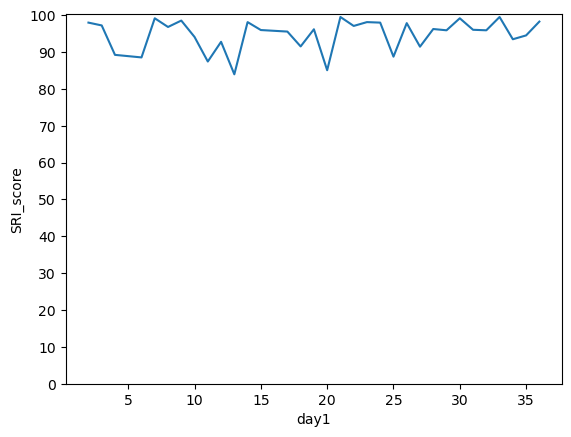

In [123]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s21_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s21_result_df_sorted = s21_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s21_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s21_result_df_sorted[s21_result_df_sorted['day_of_participation'] == day1]
    day2_df = s21_result_df_sorted[s21_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s21_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s21_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s21_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [124]:
####### subject 06 ###########
s22_df= ORC_22_df.copy()
s22_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s22_df.dropna(subset='visit_date', axis=0, inplace=True)

s22_df.head()

######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s22_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s22_full_epoch= create_full_epoch_df(s22_df)

s22_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_22,2022-10-07,2.0,-720,0
1,ORC_22,2022-10-07,2.0,-719,0
2,ORC_22,2022-10-07,2.0,-718,0
3,ORC_22,2022-10-07,2.0,-717,0
4,ORC_22,2022-10-07,2.0,-716,0


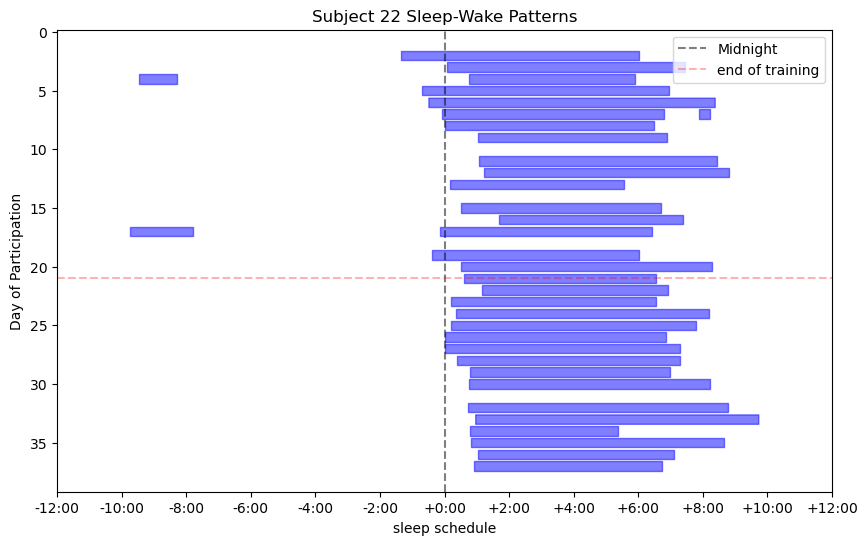

In [125]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s22_full_epoch['day_of_participation'].unique():
    day_df = s22_full_epoch[s22_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 22 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 22 sleep-wake patterns.png')

# Show the plot
plt.show()



  subject  day1  day2  SRI_score
0  ORC_22   2.0   3.0      88.19
1  ORC_22   3.0   4.0      85.90
2  ORC_22   4.0   5.0      84.65
3  ORC_22   5.0   6.0      93.40
4  ORC_22   6.0   7.0      93.12


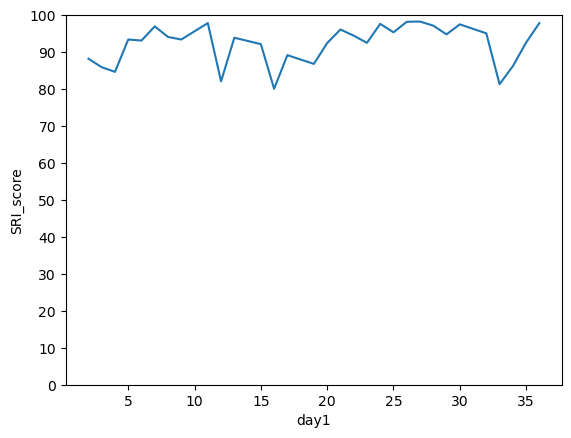

In [126]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s22_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s22_result_df_sorted = s22_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s22_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s22_result_df_sorted[s22_result_df_sorted['day_of_participation'] == day1]
    day2_df = s22_result_df_sorted[s22_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s22_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s22_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s22_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [127]:
####### subject 06 ###########
s27_df= ORC_27_df.copy()
s27_df.dropna(subset='sleep1_date_time24', axis=0, inplace=True)
s27_df.dropna(subset='visit_date', axis=0, inplace=True)

s27_df.head()

######## create time-epoch conversions ###############
convert_multiple_sleep_epochs(s27_df)

##s24_df.head()  # in case I want to confirm


############ Create full epoch df ##############

s27_full_epoch= create_full_epoch_df(s27_df)

s27_full_epoch.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORC_27,2023-03-08,2.0,-720,0
1,ORC_27,2023-03-08,2.0,-719,0
2,ORC_27,2023-03-08,2.0,-718,0
3,ORC_27,2023-03-08,2.0,-717,0
4,ORC_27,2023-03-08,2.0,-716,0


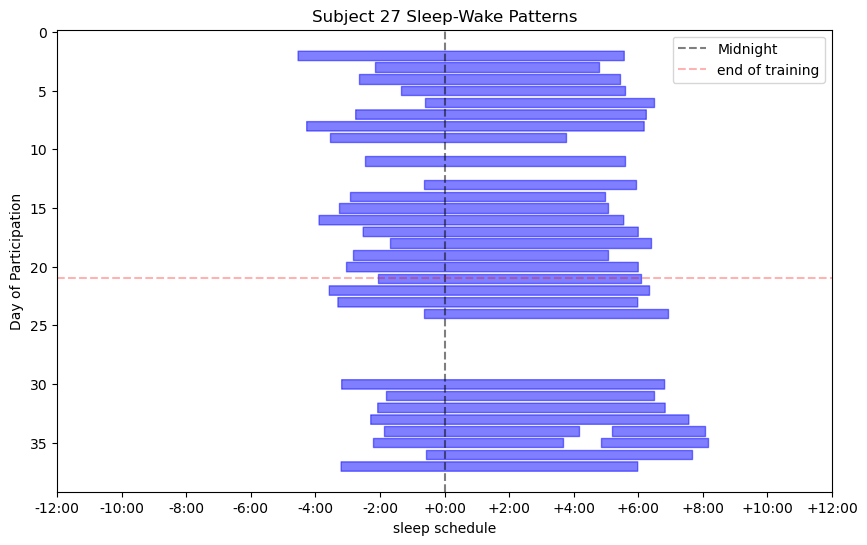

In [128]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s27_full_epoch['day_of_participation'].unique():
    day_df = s27_full_epoch[s27_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 27 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()

## save figure, if desired
plt.savefig('Subject 27 sleep-wake patterns.png')

# Show the plot
plt.show()



  subject  day1  day2  SRI_score
0  ORC_27   2.0   3.0      86.88
1  ORC_27   3.0   4.0      95.28
2  ORC_27   4.0   5.0      93.89
3  ORC_27   5.0   6.0      93.19
4  ORC_27   6.0   7.0      89.93


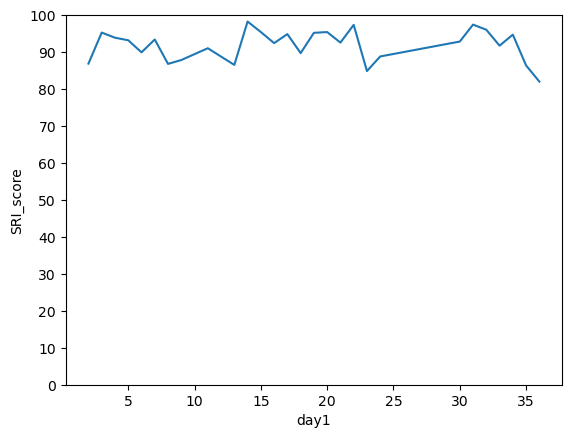

In [129]:
# # Function to calculate SRI between two successive days
# def calculate_sri(day1_df, day2_df):
#     """
#     Calculate Sleep Regularity Index (SRI) between two days.
    
#     Parameters:
#     day1_df (pd.DataFrame): Data for the first day (contains 'time_epoch' and 'SRI_index').
#     day2_df (pd.DataFrame): Data for the second day (contains 'time_epoch' and 'SRI_index').
    
#     Returns:
#     float: SRI score (percentage of matching epochs between the two days).
#     """
#     # Merge the two DataFrames on 'epoch_num' to compare each epoch between days
#     merged_df = pd.merge(day1_df[['time_epoch', 'SRI_index']], 
#                          day2_df[['time_epoch', 'SRI_index']], 
#                          on='time_epoch', 
#                          suffixes=('_day1', '_day2'))
    
#     # Calculate how many epochs have the same SRI_index for both days
#     matching_epochs = (merged_df['SRI_index_day1'] == merged_df['SRI_index_day2']).sum()
    
#     # Total number of epochs (should be 1441 if both days have full 1441-minute data)
#     total_epochs = len(merged_df)
    
#     # Calculate the SRI as the percentage of matching epochs
#     sri_score = (matching_epochs / total_epochs) * 100
    
#     return sri_score

# Example: Calculate SRI for consecutive days with subject information
sri_scores = []

###### Insert new subject data below!!! ##### 
############################################################
subject_id = s27_full_epoch['subject'].iloc[0]  # Assuming all rows have the same subject ID

# Sort the data by 'day_of_participation' to ensure correct comparison order
s27_result_df_sorted = s27_full_epoch.sort_values(by='day_of_participation')

# Get unique days of participation
unique_days = s27_result_df_sorted['day_of_participation'].unique()

# Iterate through each consecutive pair of days to calculate SRI
for i in range(1, len(unique_days)):
    day1 = unique_days[i-1]
    day2 = unique_days[i]
    
    # Extract data for the two days
    day1_df = s27_result_df_sorted[s27_result_df_sorted['day_of_participation'] == day1]
    day2_df = s27_result_df_sorted[s27_result_df_sorted['day_of_participation'] == day2]
    
    # Calculate SRI between the two days
    sri_score = calculate_sri(day1_df, day2_df)
    
    # Store the SRI score along with the day comparison and subject_id
    sri_scores.append({
        'subject': subject_id,  # Add subject_id to each row
        'day1': day1,
        'day2': day2,
        'SRI_score': sri_score
    })

# Convert the SRI scores into a DataFrame for easier viewing
s27_sri_scores_df = pd.DataFrame(sri_scores)

# View the SRI scores
print((s27_sri_scores_df).head().round(2))


ax= sns.lineplot(data=s27_sri_scores_df, x='day1', y='SRI_score')
ax.set_yticks(np.arange(0,101,10))
# ax.set_yticks(np.arange(50,111,10))

plt.show()


In [130]:
print((s27_sri_scores_df).head(40).round(1))

   subject  day1  day2  SRI_score
0   ORC_27   2.0   3.0       86.9
1   ORC_27   3.0   4.0       95.3
2   ORC_27   4.0   5.0       93.9
3   ORC_27   5.0   6.0       93.2
4   ORC_27   6.0   7.0       89.9
5   ORC_27   7.0   8.0       93.4
6   ORC_27   8.0   9.0       86.8
7   ORC_27   9.0  11.0       87.8
8   ORC_27  11.0  13.0       91.0
9   ORC_27  13.0  14.0       86.5
10  ORC_27  14.0  15.0       98.3
11  ORC_27  15.0  16.0       95.4
12  ORC_27  16.0  17.0       92.4
13  ORC_27  17.0  18.0       94.9
14  ORC_27  18.0  19.0       89.7
15  ORC_27  19.0  20.0       95.2
16  ORC_27  20.0  21.0       95.4
17  ORC_27  21.0  22.0       92.6
18  ORC_27  22.0  23.0       97.4
19  ORC_27  23.0  24.0       84.9
20  ORC_27  24.0  30.0       88.8
21  ORC_27  30.0  31.0       92.8
22  ORC_27  31.0  32.0       97.4
23  ORC_27  32.0  33.0       96.0
24  ORC_27  33.0  34.0       91.7
25  ORC_27  34.0  35.0       94.7
26  ORC_27  35.0  36.0       86.4
27  ORC_27  36.0  37.0       82.0


In [131]:
s01_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df


# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df
# s27_sri_scores_df

,subject,day1,day2,SRI_score
0,ORE_01,2.0,3.0,97.777778
1,ORE_01,3.0,4.0,97.847222
2,ORE_01,4.0,5.0,96.875000
3,ORE_01,5.0,6.0,98.472222
4,ORE_01,6.0,7.0,98.194444
5,ORE_01,7.0,8.0,95.763889
6,ORE_01,8.0,9.0,97.152778
7,ORE_01,9.0,10.0,96.388889
8,ORE_01,10.0,11.0,92.986111
9,ORE_01,11.0,12.0,95.208333


# Bring all subject data together

**concat subject data into SRI and epoch dfs**

In [133]:
SRI_combined_df= pd.concat([s01_sri_scores_df,
s02_sri_scores_df,
s03_sri_scores_df,
s04_sri_scores_df,
s05_sri_scores_df,
s06_sri_scores_df,
s09_sri_scores_df,
s10_sri_scores_df,
s11_sri_scores_df,
s12_sri_scores_df,
s15_sri_scores_df,
s20_sri_scores_df,
s21_sri_scores_df,
s22_sri_scores_df,
s23_sri_scores_df,
s24_sri_scores_df,
s25_sri_scores_df,
s27_sri_scores_df], ignore_index=True)

SRI_combined_df.head()

,subject,day1,day2,SRI_score
0,ORE_01,2.0,3.0,97.777778
1,ORE_01,3.0,4.0,97.847222
2,ORE_01,4.0,5.0,96.875000
3,ORE_01,5.0,6.0,98.472222
4,ORE_01,6.0,7.0,98.194444


In [134]:
TR =['ORE_01', 'ORE_03', 'ORE_05', 'ORE_09', 'ORE_10', 'ORE_11', 'ORE_18', 'ORE_19', 'ORE_23', 'ORE_24', 'ORE_25']

AD= ['ORE_01','ORE_05', 'ORE_09','ORE_18', 'ORE_19', 'ORE_23', 'ORE_24', 'ORE_25']

OR= ['ORE_03','ORE_10', 'ORE_11']

In [135]:
con=['ORC_02', 'ORC_04', 'ORC_06', 'ORC_12', 'ORC_15', 'ORC_20', 'ORC_21', 'ORC_23', 'ORC_27']

In [136]:
Training_days= np.arange(2,24,1)

print(Training_days)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [137]:
full_epoch_combined_df= pd.concat([s01_full_epoch,
s02_full_epoch,
s03_full_epoch,
s04_full_epoch,
s05_full_epoch,
s06_full_epoch,
s09_full_epoch,
s10_full_epoch,
s11_full_epoch,
s12_full_epoch,
s15_full_epoch,
s20_full_epoch,
s21_full_epoch,
s22_full_epoch,
s23_full_epoch,
s24_full_epoch,
s25_full_epoch,
s27_full_epoch], axis=0, ignore_index=True)


full_epoch_combined_df.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index
0,ORE_01,2021-06-08,2.0,-720,0
1,ORE_01,2021-06-08,2.0,-719,0
2,ORE_01,2021-06-08,2.0,-718,0
3,ORE_01,2021-06-08,2.0,-717,0
4,ORE_01,2021-06-08,2.0,-716,0


In [138]:
full_epoch_combined_df.shape

(925920, 5)

In [139]:
full_epoch_combined_df['train_cat']=None
full_epoch_combined_df.loc[full_epoch_combined_df['subject'].isin(TR), 'train_cat'] = 'TR'
full_epoch_combined_df.loc[full_epoch_combined_df['subject'].isin(con), 'train_cat'] = 'CON'

full_epoch_combined_df['ot_status']=None
full_epoch_combined_df.loc[full_epoch_combined_df['subject'].isin(AD), 'ot_status'] = 'AD'
full_epoch_combined_df.loc[full_epoch_combined_df['subject'].isin(con), 'ot_status'] = 'CON'
full_epoch_combined_df.loc[full_epoch_combined_df['subject'].isin(OR), 'ot_status'] = 'OR'

full_epoch_combined_df.loc[full_epoch_combined_df['day_of_participation'].isin(Training_days), 'phase'] = 'Training'
full_epoch_combined_df.loc[~full_epoch_combined_df['day_of_participation'].isin(Training_days), 'phase'] = 'Recovery'


In [140]:
full_epoch_combined_df.head()

,subject,visit_date,day_of_participation,time_epoch,SRI_index,train_cat,ot_status,phase
0,ORE_01,2021-06-08,2.0,-720,0,TR,AD,Training
1,ORE_01,2021-06-08,2.0,-719,0,TR,AD,Training
2,ORE_01,2021-06-08,2.0,-718,0,TR,AD,Training
3,ORE_01,2021-06-08,2.0,-717,0,TR,AD,Training
4,ORE_01,2021-06-08,2.0,-716,0,TR,AD,Training


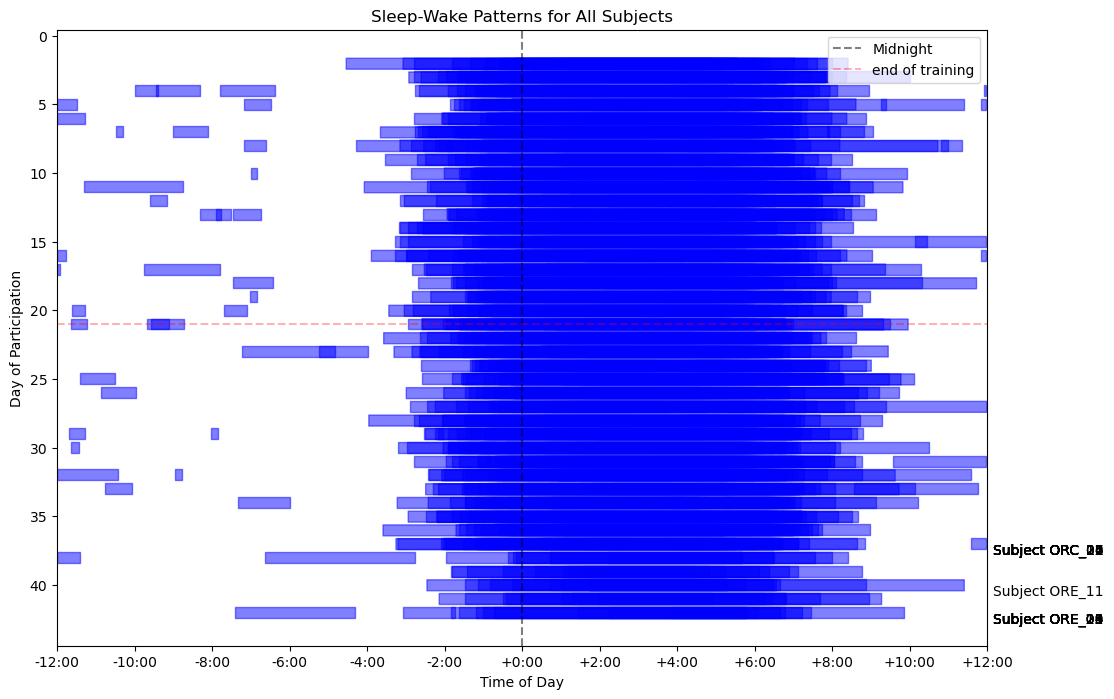

In [141]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Define the list of subjects
subjects = full_epoch_combined_df['subject'].unique()

# Create a figure and axis for the plot
plt.figure(figsize=(12, 8))

# Loop through each subject
for subject in subjects:
    subject_df = full_epoch_combined_df[full_epoch_combined_df['subject'] == subject]
    
    # Loop through each day of participation for the current subject
    for day in subject_df['day_of_participation'].unique():
        day_df = subject_df[subject_df['day_of_participation'] == day]
        plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

    # Add subject label to the plot
    plt.text(730, day + 0.5, f'Subject {subject}', ha='left', va='center', fontsize=10)

# Customize the overall plot

# Customize plot per subject
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("Time of Day")
plt.ylabel("Day of Participation")
plt.title("Sleep-Wake Patterns for All Subjects")
plt.legend()

# Invert the y-axis to have Day 1 on top
plt.gca().invert_yaxis()

# Show the plot
plt.show()


In [142]:
CON_full_epoch_combined_df= full_epoch_combined_df[full_epoch_combined_df['train_cat']=='CON']

TR_full_epoch_combined_df= full_epoch_combined_df[full_epoch_combined_df['train_cat']=='TR']

AD_full_epoch_combined_df= full_epoch_combined_df[full_epoch_combined_df['ot_status']=='AD']

OR_full_epoch_combined_df= full_epoch_combined_df[full_epoch_combined_df['ot_status']=='OR']

NameError: name 'palette' is not defined

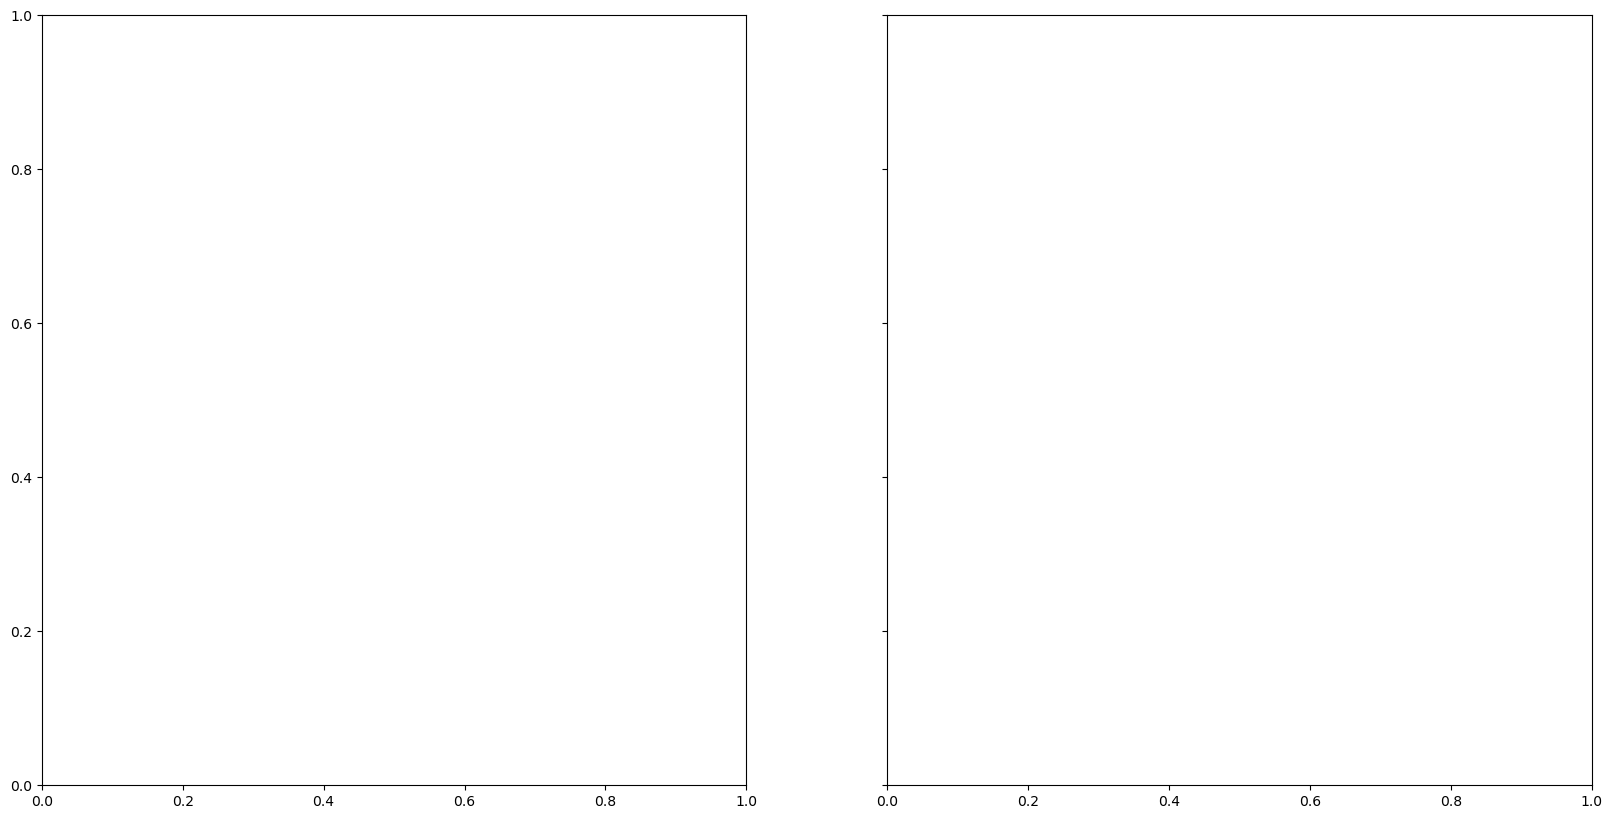

In [143]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Define the list of subjects
Con_subjects= CON_full_epoch_combined_df['subject'].unique()
TR_subjects = TR_full_epoch_combined_df['subject'].unique()

# Create the subplots
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

# Loop through the first half of subjects and plot on the first subplot
for subject in Con_subjects:
    subject_df = CON_full_epoch_combined_df[CON_full_epoch_combined_df['subject'] == subject]
    
    # Loop through each day of participation for the current subject
    for day in subject_df['day_of_participation'].unique():
        day_df = subject_df[subject_df['day_of_participation'] == day]
        ax[0].fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color=palette[0], alpha=0.2, label=None)

    # Add subject label to the first subplot
    # ax[0].text(730, day + 0.5, f'Subject {subject}', ha='left', va='center', fontsize=10)

# Customize the first subplot
ax[0].axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center
ax[0].axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='End of training', alpha=0.3)
ax[0].set_xlim(-720, 720)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_tick_labels)
ax[0].set_xlabel("Time of Day")
ax[0].set_title("Sleep-Wake Patterns (Control Participants)")

# Loop through the second half of subjects and plot on the second subplot
for subject in TR_subjects:
    subject_df = TR_full_epoch_combined_df[TR_full_epoch_combined_df['subject'] == subject]
    
    # Loop through each day of participation for the current subject
    for day in subject_df['day_of_participation'].unique():
        day_df = TR_full_epoch_combined_df[TR_full_epoch_combined_df['day_of_participation'] == day]
        ax[1].fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color=palette[1], alpha=0.1)

    # Add subject label to the second subplot
    # ax[1].text(730, day + 0.5, f'Subject {subject}', ha='left', va='center', fontsize=10)

# Customize the second subplot
ax[1].axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center
ax[1].axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='End of training', alpha=0.3)
ax[1].set_xlim(-720, 720)
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_tick_labels)
ax[1].set_xlabel("Time of Day")
ax[1].set_title("Sleep-Wake Patterns (Training Participants)")

# Invert the y-axis to have Day 1 on top for both subplots
ax[0].invert_yaxis()

# Set y-axis label for the first subplot (shared with the second)
ax[0].set_ylabel("Day of Participation")

# Add legends to both subplots
ax[0].legend()
ax[1].legend()

# Show the plot
plt.tight_layout()

plt.savefig('CON-TR sleep-wake patterns (overlay).png')
plt.show()


In [ ]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Define the list of subjects
Con_subjects= CON_full_epoch_combined_df['subject'].unique()
AD_subjects = AD_full_epoch_combined_df['subject'].unique()
OR_subjects = OR_full_epoch_combined_df['subject'].unique()

# Create the subplots
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 10))

# Loop through Control subjects
for subject in Con_subjects:
    subject_df = CON_full_epoch_combined_df[CON_full_epoch_combined_df['subject'] == subject]
    
    # Loop through each day of participation for the current subject
    for day in subject_df['day_of_participation'].unique():
        day_df = subject_df[subject_df['day_of_participation'] == day]
        ax[0].fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color=palette[0], alpha=0.2, label=None)

    # Add subject label to the first subplot
    # ax[0].text(730, day + 0.5, f'Subject {subject}', ha='left', va='center', fontsize=10)

# Customize the first subplot
ax[0].axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center
ax[0].axhline(xmin=0, xmax=1, y=21, ls='--', color='red', lw=2, label='End of training', alpha=0.3)
ax[0].set_xlim(-720, 720)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_tick_labels, rotation=45)
ax[0].set_xlabel("Time of Day")
ax[0].set_title("Sleep-Wake Patterns (Control Participants)")

# Loop through Control subjects
for subject in AD_subjects:
    subject_df = AD_full_epoch_combined_df[AD_full_epoch_combined_df['subject'] == subject]
    
    # Loop through each day of participation for the current subject
    for day in subject_df['day_of_participation'].unique():
        day_df = subject_df[subject_df['day_of_participation'] == day]
        ax[1].fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color=palette[1], alpha=0.1)

    # Add subject label to the second subplot
    # ax[1].text(730, day + 0.5, f'Subject {subject}', ha='left', va='center', fontsize=10)

# Customize the second subplot
ax[1].axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center
ax[1].axhline(xmin=0, xmax=1, y=21, ls='--', color='red', lw=2,label='End of training', alpha=0.3)
ax[1].set_xlim(-720, 720)
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_tick_labels, rotation=45)
ax[1].set_xlabel("Time of Day")
ax[1].set_title("Sleep-Wake Patterns (Adapted Participants)")


# Loop through Overreached subjects
for subject in OR_subjects:
    subject_df = OR_full_epoch_combined_df[OR_full_epoch_combined_df['subject'] == subject]
    
    # Loop through each day of participation for the current subject
    for day in subject_df['day_of_participation'].unique():
        day_df = OR_full_epoch_combined_df[OR_full_epoch_combined_df['day_of_participation'] == day]
        ax[2].fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color=palette[2], alpha=0.1)

    # Add subject label to the second subplot
    # ax[1].text(730, day + 0.5, f'Subject {subject}', ha='left', va='center', fontsize=10)

# Customize the second subplot
ax[2].axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center
ax[2].axhline(xmin=0, xmax=1, y=21, ls='--', color='red',lw=2, label='End of training', alpha=0.3)
ax[2].set_xlim(-720, 720)
ax[2].set_xticks(x_ticks)
ax[2].set_xticklabels(x_tick_labels, rotation=45)
ax[2].set_xlabel("Time of Day")
ax[2].set_title("Sleep-Wake Patterns (Overreached Participants)")

# Invert the y-axis to have Day 1 on top for both subplots
ax[0].invert_yaxis()

# Set y-axis label for the first subplot (shared with the second)
ax[0].set_ylabel("Day of Participation")

# Add legends to both subplots
ax[0].legend()
ax[1].legend()

# Show the plot
plt.tight_layout()

plt.savefig('CON-AD-OR sleep-wake patterns (overlay).png')

plt.show()


In [ ]:
SRI_combined_df= pd.concat([s01_sri_scores_df,
s02_sri_scores_df,
s03_sri_scores_df,
s04_sri_scores_df,
s05_sri_scores_df,
s06_sri_scores_df,
s09_sri_scores_df,
s10_sri_scores_df,
s11_sri_scores_df,
s12_sri_scores_df,
s15_sri_scores_df,
s20_sri_scores_df,
s21_sri_scores_df,
s22_sri_scores_df,
s23_sri_scores_df,
s24_sri_scores_df,
s25_sri_scores_df,
s27_sri_scores_df], ignore_index=True)

SRI_combined_df['train_cat']=None
SRI_combined_df.loc[SRI_combined_df['subject'].isin(TR), 'train_cat'] = 'TR'
SRI_combined_df.loc[SRI_combined_df['subject'].isin(con), 'train_cat'] = 'CON'

SRI_combined_df['ot_status']=None
SRI_combined_df.loc[SRI_combined_df['subject'].isin(AD), 'ot_status'] = 'AD'
SRI_combined_df.loc[SRI_combined_df['subject'].isin(con), 'ot_status'] = 'CON'
SRI_combined_df.loc[SRI_combined_df['subject'].isin(OR), 'ot_status'] = 'OR'

SRI_combined_df.head()

In [ ]:
SRI_combined_df['phase']= None

SRI_combined_df.loc[SRI_combined_df['day1'].isin(Training_days), 'phase'] = 'Training'
SRI_combined_df.loc[~SRI_combined_df['day1'].isin(Training_days), 'phase'] = 'Recovery'

SRI_combined_df.head()

In [ ]:
SRI_combined_df['ot_status']= pd.Categorical(SRI_combined_df['ot_status'], categories=['CON', 'AD', 'OR'], ordered=True)
SRI_combined_df['train_cat']= pd.Categorical(SRI_combined_df['train_cat'], categories=['CON', 'TR'], ordered=True)

In [ ]:
CON_SRI_combined_df = SRI_combined_df[SRI_combined_df['train_cat']=='CON']

TR_SRI_combined_df = SRI_combined_df[SRI_combined_df['train_cat']=='TR']

AD_SRI_combined_df = SRI_combined_df[SRI_combined_df['ot_status']=='AD']

OR_SRI_combined_df = SRI_combined_df[SRI_combined_df['ot_status']=='OR']

In [ ]:
palette=sns.color_palette()

In [ ]:
fig, ax=plt.subplots(1,3, sharey=True, figsize=(14,4))



ax1= sns.lineplot(data=CON_SRI_combined_df, x='day1', y='SRI_score', ax=ax[0], color=palette[0])
# ax1.get_legend().remove()
ax1.axvline(x=21, ymin=0, ymax=1, ls='--', color='red', label='end of training')


ax2=sns.lineplot(data=AD_SRI_combined_df, x='day1', y='SRI_score', ax=ax[1], color=palette[1])
ax2.axvline(x=21, ymin=0, ymax=1, ls='--', color='red', label='end of training')

ax3=sns.lineplot(data=OR_SRI_combined_df, x='day1', y='SRI_score', ax=ax[2], color=palette[2])
ax3.axvline(x=21, ymin=0, ymax=1, ls='--', color='red', label='end of training')

plt.tight_layout()
plt.show()

In [ ]:
SRI_combined_df.groupby(['day1', 'ot_status'], observed=False)['SRI_score'].describe().round(2)

# agg_SRI.to_excel('agg_SRI scores 10.23.24.xlsx')

In [ ]:
agg_SRI= SRI_combined_df.groupby(['day1', 'ot_status'], observed=False)['SRI_score'].describe().round(2)

agg_SRI.to_excel('agg_SRI scores 10.23.24.xlsx')

In [ ]:


sns.catplot(data=SRI_combined_df, x='day1', y='SRI_score', col='ot_status', kind='point', hue='ot_status')

plt.xticks(np.arange(0,43,7))

plt.grid(True)
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(8,4))

ax= sns.lineplot(data=SRI_combined_df, x='day1', y='SRI_score', hue='ot_status')
# ax.set_yticks(np.arange(0,101,10))
ax.set_yticks(np.arange(50,111,10))


ax.axvline(ymin=0, ymax=1, x=21, ls='--', color='red', alpha=0.5, label='end of training')

plt.legend()


plt.show()

In [ ]:
SRI_combined_df.to_excel('SRI_combined_df 10.23.24.xlsx')

In [ ]:
# Create x-ticks from -720 to 720 with 120-epoch intervals (every 2 hours)
x_ticks = np.arange(-720, 721, 120)

# Generate corresponding time labels for these ticks
x_tick_labels = [epoch_to_time(epoch) for epoch in x_ticks]

# Plot the data
plt.figure(figsize=(10, 6))

# Loop through each day of participation and plot
for day in s22_full_epoch['day_of_participation'].unique():
    day_df = s22_full_epoch[s22_full_epoch['day_of_participation'] == day]
    plt.fill_between(day_df['time_epoch'], day - 0.4, day + 0.4, where=day_df['SRI_index'] == 1, color='blue', alpha=0.5)

# Customize plot
plt.axvline(x=0, color='black', linestyle='--', label="Midnight", alpha=0.5)  # Annotate midnight at center

#annotate end of training
plt.axhline(xmin=0, xmax=1, y=21, ls='--', color='red', label='end of training', alpha=0.3)


plt.xlim(-720, 720)
plt.xticks(x_ticks, x_tick_labels)  # Set x-ticks and labels
plt.xlabel("sleep schedule")
plt.ylabel("Day of Participation")
plt.title("Subject 22 Sleep-Wake Patterns")
plt.legend()

#invert the y-axis
plt.gca().invert_yaxis()


# Show the plot
plt.show()



In [ ]:
#final walkthrough above

# Notes for what I've done so far

create a dateframe where for each day (col), time_of_day is represented both by the time (00:00) in one col and the corresponding epoch (1,1440) in another. 

pull an indidual subject's data (ex: subject_1)
convert any time-series date to date-time (pd.to_datetime())

create new columns of data so that sleep-wake times are each represented by their corresponding time_epoch
    if sleep_date.date() < visit_date.date(), -1440 to convert sleep time to day before
    **important** 
    0:00 of visit_date time of day --> 1 time_epoch
    12:00 of day before = -720
    12:00 of visit_date time of day --> 720 time epoch

    day-to-day= noon to noon (-720 to 720, -12:00 to +12:00)

